## Replicating the Wind Direction Forecast Algorithm
From Howland et al.: Closed-loop wake steering: Diurnal cycle ABL

#### Linear Ridge / Lasso Regression approach

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

First process the data into its training, testing and validation sets

![data process](alg-data-processing.png)

In [6]:
# parse data set into t_1 (past), t_2 (present), t_3 (future)
meters = 40 # deinfe where to use wind dir measurements from either 40, 100 m above ground
T = 15 * 60 # 15 minutes in seconds

In [7]:
def parse_data(data_df, T, x_features=["t"]):
    parse_model_data = pd.DataFrame()

    for x_ft in x_features:
        # past time and wind direction goes from t_initial -> t_final - 2T
        parse_model_data[f"{x_ft}1"] = data_df[x_ft][:-2*T]
        parse_model_data["e_t1"] = data_df[f"wind direction at {meters}m (deg)"][:-2*T]
        parse_model_data["e_t1_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][:-2*T]))
        parse_model_data["e_t1_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][:-2*T]))


        # present time and wind direction goes from t_initial + T -> t_final - T
        parse_model_data[f"{x_ft}2"] = data_df[x_ft][T:-T]
        parse_model_data["e_t2"] = data_df[f"wind direction at {meters}m (deg)"][T:-T]
        parse_model_data["e_t2_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][T:-T]))
        parse_model_data["e_t2_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][T:-T]))

        # future time and wind direction goes from t_0 + 2T -> t_final
        parse_model_data[f"{x_ft}3"] = data_df[x_ft][2*T:]
        parse_model_data["e_t3"] = data_df[f"wind direction at {meters}m (deg)"][2*T:]
        parse_model_data["e_t3_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][2*T:]))
        parse_model_data["e_t3_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][2*T:]))

    return parse_model_data

In [8]:
all_india_data_df = pd.read_csv("data/NREL data/all_NREL_india_wind_data_2014.csv")
x_features = ["t", "temperature at 120m (C)", "air pressure at 40m (Pa)", "wind speed at 80m (m/s)"]
parsed_model_data = parse_data(all_india_data_df, T, x_features)
parsed_model_data

t1    e_t1  e_t1_sin  e_t1_cos            t2    e_t2  \
0      1388534400000000000   61.15  0.875886  0.482518           NaN     NaN   
1      1388535300000000000   56.90  0.837719  0.546102           NaN     NaN   
2      1388536200000000000   54.70  0.816138  0.577858           NaN     NaN   
3      1388537100000000000   51.25  0.779884  0.625923           NaN     NaN   
4      1388538000000000000   48.28  0.746406  0.665491           NaN     NaN   
...                    ...     ...       ...       ...           ...     ...   
33235  1418445900000000000  230.09 -0.767053 -0.641584  1.418446e+18  230.09   
33236  1418446800000000000  233.17 -0.800418 -0.599443  1.418447e+18  233.17   
33237  1418447700000000000  231.69 -0.784668 -0.619916  1.418448e+18  231.69   
33238  1418448600000000000  227.42 -0.736333 -0.676619  1.418449e+18  227.42   
33239  1418449500000000000  225.40 -0.712026 -0.702153  1.418450e+18  225.40   

       e_t2_sin  e_t2_cos            t3    e_t3  ...  e_t3_cos  \
0           NaN       NaN           NaN     NaN  ...       NaN   
1           NaN       NaN           NaN     NaN  ...       NaN   
2           NaN       NaN           NaN     NaN  ...       NaN   
3           NaN       NaN           NaN     NaN  ...       NaN   
4           NaN       NaN           NaN     NaN  ...       NaN   
...         ...       ...           ...     ...  ...       ...   
33235 -0.767053 -0.641584  1.418446e+18  230.09  ... -0.641584   
33236 -0.800418 -0.599443  1.418447e+18  233.17  ... -0.599443   
33237 -0.784668 -0.619916  1.418448e+18  231.69  ... -0.619916   
33238 -0.736333 -0.676619  1.418449e+18  227.42  ... -0.676619   
33239 -0.712026 -0.702153  1.418450e+18  225.40  ... -0.702153   

       temperature at 120m (C)1  temperature at 120m (C)2  \
0                         12.23                       NaN   
1                         12.13                       NaN   
2                         12.02                       NaN   
3                         11.90                       NaN   
4                         11.76                       NaN   
...                         ...                       ...   
33235                     21.29                     21.29   
33236                     21.93                     21.93   
33237                     22.38                     22.38   
33238                     22.62                     22.62   
33239                     22.73                     22.73   

       temperature at 120m (C)3  air pressure at 40m (Pa)1  \
0                           NaN                      97370   
1                           NaN                      97370   
2                           NaN                      97370   
3                           NaN                      97380   
4                           NaN                      97390   
...                         ...                        ...   
33235                     21.29                      96880   
33236                     21.93                      96880   
33237                     22.38                      96880   
33238                     22.62                      96880   
33239                     22.73                      96880   

       air pressure at 40m (Pa)2  air pressure at 40m (Pa)3  \
0                            NaN                        NaN   
1                            NaN                        NaN   
2                            NaN                        NaN   
3                            NaN                        NaN   
4                            NaN                        NaN   
...                          ...                        ...   
33235                    96880.0                    96880.0   
33236                    96880.0                    96880.0   
33237                    96880.0                    96880.0   
33238                    96880.0                    96880.0   
33239                    96880.0                    96880.0   

       wind speed at 80m (m/s)1  wi

In [9]:
# parsing x, y train, test and validation sets
x_features_123 = [ft+str(i) for i in range(1,4) for ft in x_features]
# get x training and testing data corresponding to x_feature column
X_train, X_test, X_val = parsed_model_data[x_features_123].dropna().to_numpy(), parsed_model_data[x_features_123].dropna().to_numpy(), parsed_model_data[x_features_123].dropna().to_numpy()
X_train, X_test, X_val

(array([[1.3901544e+18, 1.5260000e+01, 9.7480000e+04, ..., 1.5260000e+01,
         9.7480000e+04, 3.2200000e+00],
        [1.3901553e+18, 1.5290000e+01, 9.7480000e+04, ..., 1.5290000e+01,
         9.7480000e+04, 3.2700000e+00],
        [1.3901562e+18, 1.5290000e+01, 9.7480000e+04, ..., 1.5290000e+01,
         9.7480000e+04, 3.2400000e+00],
        ...,
        [1.4184477e+18, 2.2380000e+01, 9.6880000e+04, ..., 2.2380000e+01,
         9.6880000e+04, 3.0300000e+00],
        [1.4184486e+18, 2.2620000e+01, 9.6880000e+04, ..., 2.2620000e+01,
         9.6880000e+04, 3.2400000e+00],
        [1.4184495e+18, 2.2730000e+01, 9.6880000e+04, ..., 2.2730000e+01,
         9.6880000e+04, 3.4100000e+00]]),
 array([[1.3901544e+18, 1.5260000e+01, 9.7480000e+04, ..., 1.5260000e+01,
         9.7480000e+04, 3.2200000e+00],
        [1.3901553e+18, 1.5290000e+01, 9.7480000e+04, ..., 1.5290000e+01,
         9.7480000e+04, 3.2700000e+00],
        [1.3901562e+18, 1.5290000e+01, 9.7480000e+04, ..., 1.5290000e+01,

In [10]:
# get x training and testing data corresponding to x_feature column
y_train, y_test, y_val = parsed_model_data[["e_t1"]].dropna().to_numpy(), parsed_model_data[["e_t2"]].dropna().to_numpy(), parsed_model_data[["e_t3"]].dropna().to_numpy()
y_train, y_test, y_val

(array([[ 61.15],
        [ 56.9 ],
        [ 54.7 ],
        ...,
        [231.69],
        [227.42],
        [225.4 ]]),
 array([[101.1 ],
        [105.57],
        [117.8 ],
        ...,
        [231.69],
        [227.42],
        [225.4 ]]),
 array([[ 81.33],
        [ 83.09],
        [ 86.59],
        ...,
        [231.69],
        [227.42],
        [225.4 ]]))

In [42]:
from sklearn.linear_model import Ridge, Lasso

def regression_direction_estimation(data_df, model_type, x_feature="t"):
    '''
    x_feature : str : column name to use as model inputs {}
    model_type : str : {'Lasso', 'Ridge'}
    '''
    # get x training and testing data corresponding to x_feature column
    X_train, X_val = data_df[["e_t1_cos", "e_t1_sin"]].dropna().to_numpy(), data_df[["e_t2_cos", "e_t2_sin"]].dropna().to_numpy()
    if x_feature:
        X_train, X_val = data_df[[x_feature+"1", "e_t1_cos", "e_t1_sin"]].dropna().to_numpy(), data_df[[x_feature+"2", "e_t2_cos", "e_t2_sin"]].dropna().to_numpy()

    # get x training and testing data corresponding to x_feature column
    y_train, y_val = data_df[["e_t2_cos", "e_t2_sin"]].dropna().to_numpy(), data_df[["e_t3_cos", "e_t3_sin"]].dropna().to_numpy()

    # standardize training and testing data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)
    # y_train = scaler.fit_transform(y_train)
    # y_val = scaler.fit_transform(y_val)

    train_mse = list()
    val_mse = list()
    coeffs = list()

    # initialize set of lambdas to conduct grid search over
    lambdas = np.logspace(-4,9,100)
    print(X_train.shape)
    min_shape = min(X_train.shape[0], X_val.shape[0], y_train.shape[0], y_val.shape[0])
    for lam in lambdas:
        ## Lasso Regression
        if model_type == "Lasso":
            # train lasso model
            model = Lasso(alpha=lam).fit(X_train[:min_shape], y_train[:min_shape])
        
        ## Ridge Regression
        elif model_type == "Ridge":
            model = Ridge(alpha=lam).fit(X_train[:min_shape], y_train[:min_shape])
        
        # compute lasso train and test errors
        # print(X_train[:min_shape])
        # print(X_train[:,0][:min_shape])
        # y_train_pred_cos = model.predict(X_train[:min_shape])
        print("True", y_train[:min_shape,0])
        
        y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
        y_train_pred = model.predict(X_train[:min_shape])
        print("Pred angles: ", y_train_pred_cos[:,0])
        train_mse.append(np.mean((y_train[:min_shape] -  y_train_pred)**2))

        y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
        y_val_pred = model.predict(X_val[:min_shape])
        val_mse.append(np.mean((y_val[:min_shape] - y_val_pred)**2))
        coeffs.append(model.coef_[0])
        
    return lambdas, train_mse, val_mse, coeffs

In [43]:
def plot_mse_coeff(data_df, model_type, x_features=["t"]):

    # create regression and plot MSEs
    lambdas, train_mse, test_mse, coeffs = regression_direction_estimation(data_df, model_type)
    df = pd.DataFrame({"lambdas": lambdas, "train_MSE": train_mse, "test_MSE": test_mse, "coeffs": coeffs})
    plt.plot(lambdas, train_mse, label="Train MSE",)
    plt.plot(lambdas, test_mse, label="Test MSE", linestyle='--')

    # create MSE plot axes and labels
    plt.title(model_type + " Regression Lambda Grid Search: MSE")
    plt.xscale('log')
    plt.xlabel("lambda")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    # plot labeled coefficients
    plt.plot(lambdas, coeffs, label="Coef.",)
    
    # create plot axes
    plt.title(model_type + " Regression Lambda Grid Search: Coefficients")
    plt.xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('coefficients')
    plt.legend()
    plt.show()
    return df


In [44]:
def plot_mse_coeffs(data_df, model_type, x_features=["t"]):
    # color code each feature x feature regression
    colors = ['red', 'blue', 'orange', 'green', 'grey']
    # store all models' MSEs and coefficients to plot later
    all_train_mses = []
    all_test_mses = []
    all_coeffs = []
    
    # create figure to plot it
    fig = plt.figure()
    ax = plt.subplot(111)
    # create regression for each feature and plot MSEs
    for i in range(len(x_features)):
        col =  x_features[i]
        print(f"Modeling {col}")
        # get regression results for model trained on feature col
        lambdas, train_mse, test_mse, coeffs = regression_direction_estimation(data_df, model_type, x_feature=col)
        # plot
        color = colors[i]
        ax.plot(lambdas, train_mse, label= col +" Train MSE", color=color)
        ax.plot(lambdas, test_mse, label= col + " Test MSE", color=color, linestyle='--')

        all_train_mses.append(train_mse)
        all_test_mses.append(test_mse)
        all_coeffs.append(coeffs)

    # create MSE plot axes and labels
    ax.set_title(model_type + " Regression Lambda Grid Search: MSE")
    ax.set_xscale('log')
    ax.set_xlabel("lambda")
    ax.set_ylabel("MSE")
    # shrink axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
    
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # create figure to plot coefficients in
    fig = plt.figure()
    ax = plt.subplot(111)
    # plot labeled coefficients
    for i in range(len(x_features)):
        col =  x_features[i]
        color = colors[i]
        ax.plot(lambdas, all_coeffs[i], label=col + " Coef.", color=color)

    
    # create plot axes
    ax.set_title(model_type + " Regression Lambda Grid Search: Coefficients")
    ax.set_xscale('log')
    ax.set_xlabel('lambda')
    ax.set_ylabel('coefficients')
    # shrink axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
    
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    return {'lambdas': lambdas, 
            'all_train_mses': all_train_mses, 
            'all_test_mses': all_test_mses, 
            'all_coeffs': all_coeffs}


In [45]:
regression_direction_estimation(parsed_model_data, model_type="Ridge")

(33240, 3)
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103102 85.64132325 ... 95.16450711 95.09160285
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103103 85.64132325 ... 95.1645071  95.09160284
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103103 85.64132326 ... 95.16450709 95.09160283
 95.0420529 ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103104 85.64132327 ... 95.16450708 95.09160282
 95.04205289]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056057 85.63103105 85.64132328 ... 95.16450705 95.09160279
 95.04205287]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61

(array([1.00000000e-04, 1.35304777e-04, 1.83073828e-04, 2.47707636e-04,
        3.35160265e-04, 4.53487851e-04, 6.13590727e-04, 8.30217568e-04,
        1.12332403e-03, 1.51991108e-03, 2.05651231e-03, 2.78255940e-03,
        3.76493581e-03, 5.09413801e-03, 6.89261210e-03, 9.32603347e-03,
        1.26185688e-02, 1.70735265e-02, 2.31012970e-02, 3.12571585e-02,
        4.22924287e-02, 5.72236766e-02, 7.74263683e-02, 1.04761575e-01,
        1.41747416e-01, 1.91791026e-01, 2.59502421e-01, 3.51119173e-01,
        4.75081016e-01, 6.42807312e-01, 8.69749003e-01, 1.17681195e+00,
        1.59228279e+00, 2.15443469e+00, 2.91505306e+00, 3.94420606e+00,
        5.33669923e+00, 7.22080902e+00, 9.77009957e+00, 1.32194115e+01,
        1.78864953e+01, 2.42012826e+01, 3.27454916e+01, 4.43062146e+01,
        5.99484250e+01, 8.11130831e+01, 1.09749877e+02, 1.48496826e+02,
        2.00923300e+02, 2.71858824e+02, 3.67837977e+02, 4.97702356e+02,
        6.73415066e+02, 9.11162756e+02, 1.23284674e+03, 1.668100

(33240, 3)
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103102 85.64132325 ... 95.16450711 95.09160285
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103103 85.64132325 ... 95.1645071  95.09160284
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103103 85.64132326 ... 95.16450709 95.09160283
 95.0420529 ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103104 85.64132327 ... 95.16450708 95.09160282
 95.04205289]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056057 85.63103105 85.64132328 ... 95.16450705 95.09160279
 95.04205287]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61

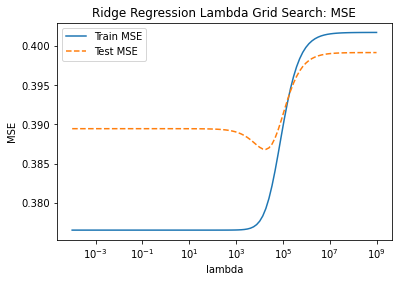

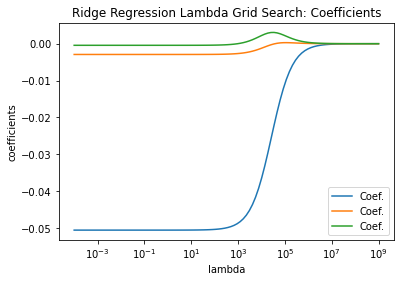

lambdas  train_MSE  test_MSE  \
0   1.000000e-04   0.376514  0.389435   
1   1.353048e-04   0.376514  0.389435   
2   1.830738e-04   0.376514  0.389435   
3   2.477076e-04   0.376514  0.389435   
4   3.351603e-04   0.376514  0.389435   
..           ...        ...       ...   
95  2.983647e+08   0.401690  0.399127   
96  4.037017e+08   0.401692  0.399129   
97  5.462277e+08   0.401693  0.399129   
98  7.390722e+08   0.401694  0.399130   
99  1.000000e+09   0.401695  0.399131   

                                               coeffs  
0   [-0.0505327879464271, -0.002919213960501174, -...  
1   [-0.050532787877156524, -0.0029192139511356988...  
2   [-0.05053278778343014, -0.0029192139384637663,...  
3   [-0.05053278765661387, -0.002919213921318034, ...  
4   [-0.0505327874850254, -0.0029192138981190404, ...  
..                                                ...  
95  [-4.718673966423767e-06, 2.6601958023050134e-0...  
96  [-3.4875333520564737e-06, 1.9662557318012724e-...  
97  [-2.5775895347698124e-06, 1.453302716689352e-0...  
98  [-1.9050524038350277e-06, 1.0741490439012348e-...  
99  [-1.4079863686686076e-06, 7.939028721323711e-0...  

[100 rows x 4 columns]

In [46]:
df = plot_mse_coeff(parsed_model_data, model_type="Ridge")
df

In [47]:
parsed_model_data

t1    e_t1  e_t1_sin  e_t1_cos            t2    e_t2  \
0      1388534400000000000   61.15  0.875886  0.482518           NaN     NaN   
1      1388535300000000000   56.90  0.837719  0.546102           NaN     NaN   
2      1388536200000000000   54.70  0.816138  0.577858           NaN     NaN   
3      1388537100000000000   51.25  0.779884  0.625923           NaN     NaN   
4      1388538000000000000   48.28  0.746406  0.665491           NaN     NaN   
...                    ...     ...       ...       ...           ...     ...   
33235  1418445900000000000  230.09 -0.767053 -0.641584  1.418446e+18  230.09   
33236  1418446800000000000  233.17 -0.800418 -0.599443  1.418447e+18  233.17   
33237  1418447700000000000  231.69 -0.784668 -0.619916  1.418448e+18  231.69   
33238  1418448600000000000  227.42 -0.736333 -0.676619  1.418449e+18  227.42   
33239  1418449500000000000  225.40 -0.712026 -0.702153  1.418450e+18  225.40   

       e_t2_sin  e_t2_cos            t3    e_t3  ...  e_t3_cos  \
0           NaN       NaN           NaN     NaN  ...       NaN   
1           NaN       NaN           NaN     NaN  ...       NaN   
2           NaN       NaN           NaN     NaN  ...       NaN   
3           NaN       NaN           NaN     NaN  ...       NaN   
4           NaN       NaN           NaN     NaN  ...       NaN   
...         ...       ...           ...     ...  ...       ...   
33235 -0.767053 -0.641584  1.418446e+18  230.09  ... -0.641584   
33236 -0.800418 -0.599443  1.418447e+18  233.17  ... -0.599443   
33237 -0.784668 -0.619916  1.418448e+18  231.69  ... -0.619916   
33238 -0.736333 -0.676619  1.418449e+18  227.42  ... -0.676619   
33239 -0.712026 -0.702153  1.418450e+18  225.40  ... -0.702153   

       temperature at 120m (C)1  temperature at 120m (C)2  \
0                         12.23                       NaN   
1                         12.13                       NaN   
2                         12.02                       NaN   
3                         11.90                       NaN   
4                         11.76                       NaN   
...                         ...                       ...   
33235                     21.29                     21.29   
33236                     21.93                     21.93   
33237                     22.38                     22.38   
33238                     22.62                     22.62   
33239                     22.73                     22.73   

       temperature at 120m (C)3  air pressure at 40m (Pa)1  \
0                           NaN                      97370   
1                           NaN                      97370   
2                           NaN                      97370   
3                           NaN                      97380   
4                           NaN                      97390   
...                         ...                        ...   
33235                     21.29                      96880   
33236                     21.93                      96880   
33237                     22.38                      96880   
33238                     22.62                      96880   
33239                     22.73                      96880   

       air pressure at 40m (Pa)2  air pressure at 40m (Pa)3  \
0                            NaN                        NaN   
1                            NaN                        NaN   
2                            NaN                        NaN   
3                            NaN                        NaN   
4                            NaN                        NaN   
...                          ...                        ...   
33235                    96880.0                    96880.0   
33236                    96880.0                    96880.0   
33237                    96880.0                    96880.0   
33238                    96880.0                    96880.0   
33239                    96880.0                    96880.0   

       wind speed at 80m (m/s)1  wi

Modeling t
(33240, 3)
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103102 85.64132325 ... 95.16450711 95.09160285
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103103 85.64132325 ... 95.1645071  95.09160284
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103103 85.64132326 ... 95.16450709 95.09160283
 95.0420529 ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103104 85.64132327 ... 95.16450708 95.09160282
 95.04205289]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056057 85.63103105 85.64132328 ... 95.16450705 95.09160279
 95.04205287]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angl

<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-i

True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.55912262 82.44006754 82.34467974 ... 90.7637364  90.87622214
 90.83265442]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.55912712 82.44007219 82.3446845  ... 90.76373475 90.87622015
 90.83265235]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.55913319 82.44007848 82.34469094 ... 90.7637325  90.87621745
 90.83264955]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.55914142 82.44008699 82.34469965 ... 90.76372947 90.8762138
 90.83264575]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.55915255 82.4400985  82.34471143 ... 90.76372536 90.87620887
 90.83264063]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.5591676  82.44

<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-i

Pred angles:  [85.17133091 85.12077607 85.07523592 ... 90.1146608  90.10302489
 90.04202602]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.69666202 85.65533184 85.61702498 ... 90.05183226 90.0294095
 89.97048085]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [86.24955347 86.21664459 86.18515381 ... 90.00637159 89.97659235
 89.9213547 ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [86.807787   86.78218955 86.75684035 ... 89.98024354 89.94672572
 89.89658393]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [87.34809073 87.32856116 87.30852644 ... 89.97228467 89.93826282
 89.89418474]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [87.84980845 87.83512638 87.81953291 ... 89.97888271 89.94681438
 89.90922691]
True [-0.19252197 -0.26

<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-i

Pred angles:  [84.30824649 84.26863009 84.2410239  ... 88.74796344 88.83655601
 88.82841893]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.3082465  84.26863011 84.24102391 ... 88.74796342 88.83655599
 88.82841891]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.30824652 84.26863012 84.24102393 ... 88.7479634  88.83655597
 88.82841889]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.30824654 84.26863015 84.24102395 ... 88.74796338 88.83655594
 88.82841886]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.30824657 84.26863018 84.24102399 ... 88.74796334 88.8365559
 88.82841882]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.30824662 84.26863023 84.24102403 ... 88.7479633  88.83655584
 88.82841876]
True [-0.19252197 -0.26

<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-i

True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.31978524 84.2807592  84.25353368 ... 88.73500585 88.82153752
 88.81311528]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.32385193 84.2850317  84.25793895 ... 88.7304995  88.81631313
 88.80779214]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.32934847 84.29080457 84.26389011 ... 88.72445813 88.80930802
 88.800655  ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.33677473 84.29860084 84.27192519 ... 88.71638505 88.79994512
 88.79111629]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.34680288 84.30912265 84.28276576 ... 88.70564415 88.78748452
 88.77842292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.36033469 84.3

<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-i

True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.85864974 89.86199376 89.85612713 ... 87.10617898 88.32502922
 89.5184186 ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.85864303 89.86198716 89.85612064 ... 87.10618286 88.32502808
 89.51841295]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.85863396 89.86197824 89.85611185 ... 87.1061881  88.32502652
 89.51840531]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.85862168 89.86196617 89.85609996 ... 87.1061952  88.32502443
 89.51839497]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.85860507 89.86194984 89.85608387 ... 87.10620479 88.32502159
 89.51838098]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.8585826  89.8

<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-i

True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.52945448 89.53787087 89.53694986 ... 87.42497371 88.34107366
 89.25837386]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.47785622 89.48692457 89.4868674  ... 87.53018566 88.37452475
 89.22482929]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.4351044  89.44462979 89.44538096 ... 87.66358369 88.42803935
 89.20295003]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.40841565 89.41810779 89.41953853 ... 87.82752596 88.50640453
 89.19952299]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.40396416 89.41347344 89.41539592 ... 88.0214221  88.61221797
 89.21996154]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.42503185 89.4

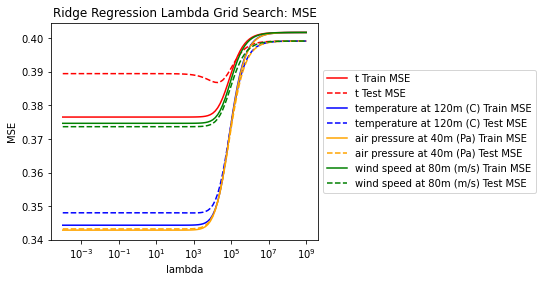

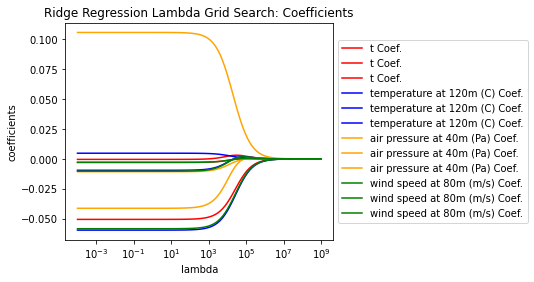

{'lambdas': array([1.00000000e-04, 1.35304777e-04, 1.83073828e-04, 2.47707636e-04,
        3.35160265e-04, 4.53487851e-04, 6.13590727e-04, 8.30217568e-04,
        1.12332403e-03, 1.51991108e-03, 2.05651231e-03, 2.78255940e-03,
        3.76493581e-03, 5.09413801e-03, 6.89261210e-03, 9.32603347e-03,
        1.26185688e-02, 1.70735265e-02, 2.31012970e-02, 3.12571585e-02,
        4.22924287e-02, 5.72236766e-02, 7.74263683e-02, 1.04761575e-01,
        1.41747416e-01, 1.91791026e-01, 2.59502421e-01, 3.51119173e-01,
        4.75081016e-01, 6.42807312e-01, 8.69749003e-01, 1.17681195e+00,
        1.59228279e+00, 2.15443469e+00, 2.91505306e+00, 3.94420606e+00,
        5.33669923e+00, 7.22080902e+00, 9.77009957e+00, 1.32194115e+01,
        1.78864953e+01, 2.42012826e+01, 3.27454916e+01, 4.43062146e+01,
        5.99484250e+01, 8.11130831e+01, 1.09749877e+02, 1.48496826e+02,
        2.00923300e+02, 2.71858824e+02, 3.67837977e+02, 4.97702356e+02,
        6.73415066e+02, 9.11162756e+02, 1.23284674e+0

In [48]:
x_features = ["t", "temperature at 120m (C)", "air pressure at 40m (Pa)", "wind speed at 80m (m/s)"]
plot_mse_coeffs(parsed_model_data, model_type="Ridge", x_features=x_features)

After doing the lambda grid search, we see that lambda (the penalty term) must be less than 10^6 because theta coefficients reach 0 at this value, meaning the regression model can no longer fit the data well.

#### Howland Algorithm

<img src="../alg-regression-pseudo.png" alt="Algorithm" width="400"/>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
def parse_data_archive(data_df, T, x_features=["t"], height_meters=40):
    parse_model_data = pd.DataFrame()

    for x_ft in x_features:
        # past time and wind direction goes from t_initial -> t_final - 2T
        parse_model_data[f"{x_ft}1"] = data_df[x_ft][:-2*T]
        parse_model_data["e_t1"] = data_df[f"wind direction at {height_meters}m (deg)"][:-2*T]
        parse_model_data["e_t1_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][:-2*T]))
        parse_model_data["e_t1_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][:-2*T]))


        # present time and wind direction goes from t_initial + T -> t_final - T
        parse_model_data[f"{x_ft}2"] = data_df[x_ft][T:-T]
        parse_model_data["e_t2"] = data_df[f"wind direction at {height_meters}m (deg)"][T:-T]
        parse_model_data["e_t2_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][T:-T]))
        parse_model_data["e_t2_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][T:-T]))


        # future time and wind direction goes from t_0 + 2T -> t_final
        parse_model_data[f"{x_ft}3"] = data_df[x_ft][2*T:]
        parse_model_data["e_t3"] = data_df[f"wind direction at {height_meters}m (deg)"][2*T:]
        parse_model_data["e_t3_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][2*T:]))
        parse_model_data["e_t3_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][2*T:]))

    return parse_model_data

In [4]:
def parse_data(data_df, T, temporal_res=15*60, x_features=["t"], height_meters=40):
    ''' 
    Parses data into all possible 3 interval datasets (t1, t2, t3) within the data's time range.
    
    param data_df : pd.DataFrame : original data to process and parse in preparation for regression
    param T : int : interval size (seconds) to train and forecast wind direction over
    param temporal_res : int : temporal resolution of data (seconds) (original NREL data is 15 mins)
    param x_features : [str] : list of paramters to train and fit model to
    param height_meters : int : either 40 or 100 (height in meters of measurements)

    returns [pd.DataFrame] : list of dataframes where each corresponds to datasets of t1, t2, t3 of size T
    '''
    # number of total model forecasting runs that can be done
    num_intervals = int(data_df.shape[0]/(T/(temporal_res)))
    # store all the t1-t3 set dataframes
    parse_model_datasets = []
    starting_t = data_df.t[0]

    for i in range(1,num_intervals+1):
        parse_model_data = pd.DataFrame()
        try:
            for x_ft in x_features:
                # past time and wind direction goes from t_initial -> t_final - 2T
                t1_condition = ((data_df.t >= starting_t) & (data_df.t < starting_t + T))
                parse_model_data[f"{x_ft}1"] = data_df[x_ft][t1_condition].values
                parse_model_data["e_t1"] = data_df[f"wind direction at {height_meters}m (deg)"][t1_condition].values
                parse_model_data["e_t1_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][t1_condition].values))
                parse_model_data["e_t1_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][t1_condition].values))

                # present time and wind direction goes from t_initial + T -> t_final - T
                t2_condition = ((data_df.t >= starting_t + 1*T -1) & (data_df.t < starting_t + 2*T))
                parse_model_data[f"{x_ft}2"] = data_df[x_ft][t2_condition].values
                parse_model_data["e_t2"] = data_df[f"wind direction at {height_meters}m (deg)"][t2_condition].values
                parse_model_data["e_t2_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][t2_condition].values))
                parse_model_data["e_t2_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][t2_condition].values))

                # future time and wind direction goes from t_0 + 2T -> t_final
                t3_condition = ((data_df.t >= starting_t + 2*T -1) & (data_df.t < starting_t + 3*T))
                parse_model_data[f"{x_ft}3"] = data_df[x_ft][t3_condition].values
                parse_model_data["e_t3"] = data_df[f"wind direction at {height_meters}m (deg)"][t3_condition].values
                parse_model_data["e_t3_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][t3_condition].values))
                parse_model_data["e_t3_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {height_meters}m (deg)"][t3_condition].values))
            
            parse_model_datasets.append(parse_model_data)
            starting_t += T
            
        except Exception as e:
                # print(e)
                continue

    return parse_model_datasets

In [5]:
# regression to be used in the wind forecasting algorithm
def regression(X, y, T,lam=1.0):
    ''' 
    param X : np.array : training X data
    param y : np.array : training y data
    param T : int : yaw set-point update period
    param lam : int : alpha coefficient of regression, a.k.a. penalty term
    '''
    # split X,y data into training and testing datasets
    test_size = 0.3 # test data represents 30% of full dataset
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)

    # standardize training and testing data
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_val = scaler.fit_transform(X_val)
    # y_train = scaler.fit_transform(y_train)
    # y_val = scaler.fit_transform(y_val)

    # fit model to training data
    model = Ridge(alpha=lam).fit(X_train, y_train)

    # calculate rsquared,  coefficient of determination
    R2_score = r2_score(y_val, model.predict(X_val))

    # compute regression train and test errors
    train_mse = (np.mean((y_train - model.predict(X_train))**2))
    val_mse = (np.mean((y_val - model.predict(X_val))**2))
    coeff = (model.coef_[0])
    
    return model, R2_score, train_mse, val_mse, coeff

In [6]:
from pyexpat import model


def algorithm(parsed_model_data_sets, T, temporal_res=15*60, R_min=0.7, lam=1.0):
    '''
    param parsed_model_data_sets : [pd.DataFrame] : list of dataframes that holds all possible chunks of t1,t2,t3 sets in the full dataset
    param t : pd.DataFrame : df with columns corresponding to t1 (t1 = t - 2T), t2 (t2 = t - T), and t3 (t3 = t + T)
    param wind_dir : pd.DataFrame : df with columns corresponding to wind direction at t: 
        t1 (t1 = t - 2T), t2 (t2 = t - T), and t3 (t3 = t + T)
    param T : int : the yaw set-point update period
    param R_min : minimum coefficient of determination value R-squared 
        (statistical measure in a regression model that determines the proportion of variance in the dependent variable 
        that can be explained by the independent variable.)
    param model_type : str : type of linear regression (Ridge or Lasso)
    param lam : int : alpha coefficient of regression, a.k.a. penalty term

    returns prediction mean, prediction standard deviation
    '''
    # count of T intervals in time series
    num_T_intervals = len(parsed_model_data_sets)

    # lists for storing results
    pred_approaches = list() # either regression or moving avg.
    model_num = list() # 1 or 2
    model_X_training_set = list() # X values for training
    model_y_training_set = list() # Y values (sin,cos) for training
    model_y_deg_training_set = list() # Y values (deg) for training
    model_y_pred_training_set = list() # fitted model y values for training set
    model_X_testing_set = list() # X values for test set
    model_y_testing_set = list() # Y values (sin,cos) for test set
    model_y_deg_testing_set = list() # Y values (deg) for test set
    train_mses = list()
    val_mses = list()
    coeffs = list()
    std_devs = list()
    preds = list()
    pred_r2_scores = list()
    true_wind_dir = list()
    test_mses = list()

    # iterate over all yaw set-point periods (T intervals) in time series
    for i in range(num_T_intervals):
        data = parsed_model_data_sets[i]
        start_t_index = i*T
        end_t_index = (i+1)*T

        # get interval of t1 and wind direction at t1 (np.array format) (sin, cos, and true degrees)
        x_t1 = data[["t1"]].fillna(0).to_numpy()
        y_t1 = data[["e_t1_cos", "e_t1_sin"]].fillna(0).to_numpy()
        y_deg_t1 = data[["e_t1"]].fillna(0).to_numpy()

        # get interval of t2 and wind direction at t2 (np.array format)
        x_t2 = data[["t2"]].fillna(0).to_numpy()
        y_t2 = data[["e_t2_cos", "e_t2_sin"]].fillna(0).to_numpy()
        y_deg_t2 = data[["e_t2"]].fillna(0).to_numpy()

        # get interval of t3 and wind direction at t3 (np.array format)
        x_t3 = data[["t3"]].fillna(0).to_numpy()
        y_t3 = data[["e_t3_cos", "e_t3_sin"]].fillna(0).to_numpy()
        y_deg_t3 = data[["e_t3"]].fillna(0).to_numpy()

        # store training datasets to lists
        model_num.extend(["1", "2"])
        model_X_training_set.extend([x_t1, x_t2])
        model_y_training_set.extend([y_t1, y_t2])
        model_y_deg_training_set.extend([y_deg_t1, y_deg_t2])
        true_wind_dir.extend([[y_deg_t2[:,0]], [y_deg_t3[:,0]]])

        # scale the training and testing datasets for models
        scaler = StandardScaler()
        X = np.concatenate((x_t1, x_t2, x_t3), axis=None)
        X_scaled = scaler.fit_transform(X.reshape(-1,1))
        # number of rows corresponding to T size intervals to parse three intervals of scaled data correctly
        T_num_rows = T//temporal_res
        print(T_num_rows)
        x_t1_scaled = X_scaled[:T_num_rows]
        x_t2_scaled = X_scaled[T_num_rows:2*T_num_rows] # scaler.fit_transform(x_t2) + T # t2 and wind dir at t2 => test dataset for model 1
        x_t3_scaled =  X_scaled[2*T_num_rows:3*T_num_rows] # scaler.fit_transform(x_t3) + 2*T # t3 and wind dir at t3 => test dataset for model 2

        # train model 1 on t1 and wind_dir at t1
        model_1, R_squared_1, train_mse_1, val_mse_1, coeff_1 = regression(x_t1_scaled, y_t1, T,lam)

        # train model 2 on t2 and wind_dir at t2
        model_2, R_squared_2, train_mse_2, val_mse_2, coeff_2 = regression(x_t2_scaled, y_t2, T,lam)

        train_mses.extend([train_mse_1, train_mse_2])
        val_mses.extend([val_mse_1, val_mse_2])
        coeffs.extend([coeff_1, coeff_2])

        # store model X and y testing sets
        model_X_testing_set.extend([x_t2, x_t3])
        model_y_testing_set.extend([y_t2, y_t3])
        model_y_deg_testing_set.extend([y_deg_t2, y_deg_t3])

        # calculate mean squared error of model 1 predictions at t2 vs true t2 data
        mse_fit = np.mean(y_t2 - model_1.predict(x_t2_scaled)**2)
        mse_mean = np.mean((y_t2 - np.mean(y_t1))**2)

        # initialize model approach indicator
        model_approach = None
        print("fit MSE", mse_fit)
        print("mean MSE ", mse_mean)
        print("R_1 ", R_squared_1)
        print("R_2 ", R_squared_2)
        
        # if prediction results are valid, calculate predictions
        if (mse_fit < mse_mean) and (R_squared_1 >= R_min) and (R_squared_2 >= R_min):
            # define model approach
            model_approach = "Regression"
            # store fitted model to training set results
            model_1_fit_t1 = model_1.predict(x_t1_scaled)
            model_2_fit_t2 = model_2.predict(x_t2_scaled)
            model_y_pred_training_set.extend([model_1_fit_t1, model_2_fit_t2])

            # predictions from model 1 and 2 on future intervals
            pred_t2 = model_1.predict(x_t2_scaled)
            pred_t3 = model_2.predict(x_t3_scaled)

            # scale results and true values to calculate mses
            y_model_1_scaled = scaler.fit_transform(y_t2)
            y_model_2_scaled = scaler.fit_transform(y_t3)

            # calculate std and MSE for models 1 and 2
            std_dev_1 = np.std(y_t2 - pred_t2)
            test_mse_1 = np.mean((y_model_1_scaled - scaler.fit_transform(pred_t2))**2)
            prediction_r2_score_1 = r2_score(y_t2, pred_t2)
            std_dev_2 = np.std(y_t3 - pred_t3)
            test_mse_2 = np.mean((y_model_2_scaled - scaler.fit_transform(pred_t3))**2)
            prediction_r2_score_2 = r2_score(y_t3, pred_t3)

            # store results
            std_devs.extend([std_dev_1, std_dev_2])
            test_mses.extend([test_mse_1, test_mse_2])
            preds.extend([pred_t2, pred_t3])
            pred_r2_scores.extend([prediction_r2_score_1, prediction_r2_score_2])
            
            # calculate test mse
            print("Regression prediction model 2 R2 score ", prediction_r2_score_2)
            

        # if not, calculate moving average
        else:
            # define model approach
            model_approach = "Moving Avg"
            
            # make prediction using moving avg approach (cos, sin)
            pred_t2 = np.mean(y_t1,axis=0)
            pred_t3 = np.mean(y_t2,axis=0)
            
            # calculate results for models 1 and 2
            std_dev_1 = np.std(y_t1)
            test_mse_1 = np.mean((y_t2 - pred_t2)**2)
            moving_avg_r2_1 = r2_score(y_t2, np.full(y_t2.shape, pred_t2))
            std_dev_2 = np.std(y_t3)
            test_mse_2 = np.mean((y_t3 - pred_t3)**2)
            moving_avg_r2_2 = r2_score(y_t3, np.full(y_t3.shape, pred_t3))
            
            # store results
            std_devs.extend([std_dev_1, std_dev_2])
            test_mses.extend([test_mse_1, test_mse_2])
            
            # store fitted model to training set (t1, t2) results = average of wind dirs during t1, t2 intervals
            model_y_pred_training_set.extend([np.array([pred_t2]*y_t3.shape[0]), np.array([pred_t3]*y_t3.shape[0])])
            preds.extend([np.array([pred_t2]*y_t3.shape[0]), np.array([pred_t3]*y_t3.shape[0])])
            pred_r2_scores.extend([moving_avg_r2_1, moving_avg_r2_2])

        # append results to storing lists
        pred_approaches.extend([model_approach, model_approach]) # either regression or moving avg.
        
        print("---------------")
    
    output = pd.DataFrame({"Model Approach": pred_approaches, "Model": model_num, "X Training set": model_X_training_set, "Y (cos,sin) Training set": model_y_training_set, "Y (deg) Training set": model_y_deg_training_set, "Model fit to training data (cos,sin)": model_y_pred_training_set,"Train MSE": train_mses, "Validation MSE": val_mses,
                "X Test set": model_X_testing_set, "Y (cos,sin) Test set": model_y_testing_set, "Y (deg) Test set": model_y_deg_testing_set, "Coeffs": coeffs, "R squared": pred_r2_scores, "Std. Dev": std_devs, "Prediction (cos,sin)": preds, "Test MSE": test_mses})
    
    return output

In [7]:
def get_degrees(cos, sin):
    '''
    cos : pd.DataFrame column
    sin : pd.DataFrame column

    return degrees corresponding to input sin and cos
    '''
    rad_cos = np.arccos(cos)
    rad_sin = np.arcsin(sin)
    rad_arctan = np.arctan2(sin,cos)
    if rad_cos.all() != rad_sin.all():
        raise Exception

    # wraps around 360°
    deg = np.rad2deg(rad_arctan)
    for i in range(len(deg)):
        if deg[i] < 0:
            deg[i] += 360

    return deg

In [8]:
def run_algorithm(data_df, T, temporal_res=15*60, R_min = 0.7, x_features=["t"], model_type="Ridge", lam=1.0, height_meters=40):
    '''
    param T : int : the yaw set-point update period
    param R_min : minimum coefficient of determination value R-squared 
        (statistical measure in a regression model that determines the proportion of variance in the dependent variable 
        that can be explained by the independent variable.)
    param model_type : str : type of linear regression (Ridge or Lasso)
    param lam : int : alpha coefficient of regression, a.k.a. penalty term
    '''
    # parse model data to have time index and wind direction columns parsed by intervals t1, t2, t3
    parsed_model_data_sets = parse_data(data_df, T, temporal_res, x_features, height_meters)

    # get prediction results
    results_df = algorithm(parsed_model_data_sets, T, temporal_res, R_min, lam)
    
    # convert cos, sin -> degrees
    results_df["Model fit to training data (cos)"] = results_df["Model fit to training data (cos,sin)"].apply(lambda x: x[:,0])
    results_df["Model fit to training data (sin)"] = results_df["Model fit to training data (cos,sin)"].apply(lambda x: x[:,1])
    results_df["Prediction (cos)"] = results_df["Prediction (cos,sin)"].apply(lambda x: x[:,0])
    results_df["Prediction (sin)"] = results_df["Prediction (cos,sin)"].apply(lambda x: x[:,1])
    train_fit_degrees = []
    test_pred_degrees = []
    for i in range(results_df.shape[0]):
        train_fit_deg = get_degrees(results_df["Model fit to training data (cos)"][i], results_df["Model fit to training data (sin)"][i])
        train_fit_degrees.append(train_fit_deg)
        test_pred_deg = get_degrees(results_df["Prediction (cos)"][i], results_df["Prediction (sin)"][i])
        test_pred_degrees.append(test_pred_deg)
    results_df["Model fit to training data (deg)"] = train_fit_degrees
    results_df["Prediction (deg)"] = test_pred_degrees

    # shift degree predicted results & recalculte MSE
    # shifting (up/down) degree for next time interval to follow trends into future
    results_df["Deg shift"] = results_df['Prediction (deg)'].apply(lambda x: x[-1] - x[0] if type(x) != float else 0.0)
    results_df["Prediction (deg) + shift"] = results_df["Prediction (deg)"] + results_df["Deg shift"]

    # recalculate MSEs
    results_df["R squared (with shift)"] = results_df[["Y (deg) Test set", "Prediction (deg) + shift"]].apply(lambda x: r2_score(x[0], x[1]))
    results_df["Test MSE (with shift)"] = results_df[["Y (deg) Test set", "Prediction (deg) + shift"]].apply(lambda x: np.mean((x[0] - x[1])**2))

    return parsed_model_data_sets, results_df

In [9]:
data_df = pd.read_csv("data/NREL data - 5min/all_NREL_india_wind_data_2014.csv")
data_df

Unnamed: 0  Year  Month  Day  Hour  Minute  \
0                0  2014      1    1     0       0   
1                1  2014      1    1     0       5   
2                2  2014      1    1     0      10   
3                3  2014      1    1     0      15   
4                4  2014      1    1     0      20   
...            ...   ...    ...  ...   ...     ...   
105115      105115  2014     12   31    23      35   
105116      105116  2014     12   31    23      40   
105117      105117  2014     12   31    23      45   
105118      105118  2014     12   31    23      50   
105119      105119  2014     12   31    23      55   

        wind direction at 120m (deg)  temperature at 40m (C)  \
0                              68.84                   12.00   
1                              68.36                   11.97   
2                              67.97                   11.93   
3                              67.71                   11.89   
4                              67.52                   11.85   
...                              ...                     ...   
105115                         73.47                   12.42   
105116                         72.45                   12.34   
105117                         71.08                   12.26   
105118                         69.95                   12.19   
105119                         69.88                   12.12   

        temperature at 120m (C)  temperature at 80m (C)  \
0                         12.23                   12.16   
1                         12.20                   12.14   
2                         12.16                   12.11   
3                         12.13                   12.08   
4                         12.09                   12.05   
...                         ...                     ...   
105115                    13.74                   13.37   
105116                    13.68                   13.30   
105117                    13.62                   13.24   
105118                    13.58                   13.18   
105119                    13.56                   13.15   

        wind speed at 120m (m/s)  air pressure at 40m (Pa)  \
0                           4.82                     97370   
1                           4.79                     97370   
2                           4.77                     97370   
3                           4.75                     97370   
4                           4.74                     97370   
...                          ...                       ...   
105115                      2.31                     96710   
105116                      2.17                     96720   
105117                      2.06                     96720   
105118                      1.99                     96720   
105119                      1.96                     96720   

        wind speed at 80m (m/s)  air pressure at 100m (Pa)  \
0                          3.76                      96670   
1                          3.76                      96670   
2                          3.76                      96670   
3                          3.77                      96680   
4                          3.78                      96670   
...                         ...                        ...   
105115                     1.59                      96030   
105116                     1.51                      96030   
105117                     1.46                      96030   
105118                     1.45                      96030   
105119                     1.47                      96040   

        wind direction at 80m (deg)  temperature at 100m (C)        Date  \
0                             62.14                    12.20    2014-1-1   
1                             61.31                    12.17    2014-1-1   
2                             60.62                    12.14    2014-1-1   
3                             60.14                    12.11    2014-1-1   
4          

In [11]:
T = 5*60*12 # 12 rows of 5 mins -> 1 hr (in seconds) 
lam = 10**(-9)
temoral_res_secs = 5*60
height_m = 80
R_min = 0.7
inputs_df, outputs_df = run_algorithm(data_df, T, temporal_res=temoral_res_secs,R_min=R_min,height_meters=height_m,lam=lam)

12
fit MSE 0.19590708261035508
mean MSE  0.00550620876507502
R_1  0.9663548007443902
R_2  0.989314624691896
---------------
12
fit MSE 0.17538364833125156
mean MSE  0.006803403950345638
R_1  -0.02601126991732311
R_2  0.9274259735917246
---------------
12
fit MSE 0.20103966221399214
mean MSE  0.0014700060620111346
R_1  0.9535699591073086
R_2  -1.1697971182594562
---------------
12
fit MSE 0.154621449439319
mean MSE  0.05528375544887015
R_1  -2.7286342666209737
R_2  0.47506225591081636
---------------
12
fit MSE 0.10195479909223902
mean MSE  0.06158894760560172
R_1  0.23999969933079485
R_2  -1.0793213349816086
---------------
12
fit MSE 0.1459940353912673
mean MSE  0.03911440029497235
R_1  -0.013718797527015825
R_2  -1.8008578513447984
---------------
12
fit MSE 0.14508323439782003
mean MSE  0.07318729230717387
R_1  -1.2779789735143163
R_2  0.6424439097839845
---------------
12
fit MSE 0.14908253192099016
mean MSE  0.0760730073866759
R_1  0.638806372867241
R_2  0.9712567722434051
-------

<ipython-input-7-1dc5b09c2dae>:9: RuntimeWarning: invalid value encountered in arcsin
  rad_sin = np.arcsin(sin)
<ipython-input-7-1dc5b09c2dae>:8: RuntimeWarning: invalid value encountered in arccos
  rad_cos = np.arccos(cos)


In [12]:
reg_results = outputs_df[outputs_df["Model Approach"]=="Regression"]
reg_results.shape[0]/outputs_df.shape[0]

0.1536880566339347

In [13]:
def plot_mses(results_df, lam, height_meters=40):
    # color code each feature x saleprice regression
    colors = ['red', 'blue', 'orange', 'green', 'grey']
    
    regression_condition = (results_df["Model Approach"] == "Regression")
    low_pass_condition = (results_df["Model Approach"] == "Moving Avg")

    model_1_condition = (results_df.Model == "1")
    model_2_condition = (results_df.Model == "2")

    mses_to_plot = ["Train MSE", "Validation MSE", "Test MSE"]
    line_styles = ["solid", "dashed", "dotted"]

    print("Ridge Regression MSE results (models 1 & 2), lam=",lam)
    print("Training MSE (mean, std): ", np.mean(results_df.loc[regression_condition]["Train MSE"].values), 
                        np.std(results_df.loc[regression_condition]["Train MSE"].values))
    print("Validation MSE (mean, std): ", np.mean(results_df.loc[regression_condition]["Validation MSE"].values),
                        np.std(results_df.loc[regression_condition]["Validation MSE"].values))
    print("Test MSE (mean, std): ", np.mean(results_df.loc[regression_condition]["Test MSE"].values),
                        np.std(results_df.loc[regression_condition]["Test MSE"].values))

    for i in range(len(mses_to_plot)):
        # plot model 1
        mean_model_1 = np.mean(results_df.loc[regression_condition & model_1_condition][mses_to_plot[i]].dropna().values)
        plt.plot(0, mean_model_1, label="Model 1 "+mses_to_plot[i], color="red", linestyle=line_styles[i])
        # plot model 2
        # plt.plot(range(np.mean(results_df.loc[regression_condition & model_2_condition][mses_to_plot[i]].dropna())), np.mean(results_df.loc[regression_condition & model_2_condition][mses_to_plot[i]].dropna().values), label="Model 2 "+mses_to_plot[i], color="blue", linestyle=line_styles[i])

    # create MSE plot axes and labels
    plt.title(f"Ridge Regression (alpha={lam})MSE - Wind Direction ({height_meters}m)")
    plt.xlabel("T interval index")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()
    print("-----------------------")

    print("Low Pass Filter MSE results (models 1 & 2)")
    print("Training MSE (mean, std): ", np.mean(results_df.loc[low_pass_condition]["Train MSE"].values), 
                        np.std(results_df.loc[low_pass_condition]["Train MSE"].values))
    print("Validation MSE (mean, std): ", np.mean(results_df.loc[low_pass_condition]["Validation MSE"].values),
                        np.std(results_df.loc[low_pass_condition]["Validation MSE"].values))
    print("Test MSE (mean, std): ", np.mean(results_df.loc[low_pass_condition]["Test MSE"].values),
                        np.std(results_df.loc[low_pass_condition]["Test MSE"].values))
    
    for i in range(len(mses_to_plot)):
        # plot model 1
        plt.plot(range(results_df.loc[low_pass_condition & model_1_condition][mses_to_plot[i]].dropna().shape[0]), results_df.loc[low_pass_condition & model_1_condition][mses_to_plot[i]].dropna(), label="Model 1 "+mses_to_plot[i], color="red", linestyle=line_styles[i])
        # plot model 2
        plt.plot(range(results_df.loc[low_pass_condition & model_2_condition][mses_to_plot[i]].dropna().shape[0]), results_df.loc[low_pass_condition & model_2_condition][mses_to_plot[i]].dropna(), label="Model 2 "+mses_to_plot[i], color="blue", linestyle=line_styles[i])

    # create MSE plot axes and labels
    plt.title(f"Moving Average MSE - Wind Direction ({height_meters}m)")
    plt.xlabel("T interval index")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

In [14]:
def plot_true_v_pred(inputs, outputs, reg_lam, t_interval_index=0, height_meters=40):
    # filtering by model 1 and 2
    model_1_df = outputs.loc[outputs.Model == "1"]
    model_2_df = outputs.loc[outputs.Model == "2"]

    # model approach (regression or moving avg.)
    model_method = model_1_df[model_1_df.index==t_interval_index]["Model Approach"].values
    # print(model_method)
    
    # t indices
    t1 = model_1_df[model_1_df.index==t_interval_index]["X Training set"].values[0][:,0]
    t2 = model_1_df[model_1_df.index==t_interval_index]["X Test set"].values[0][:,0]
    t3 = model_2_df[model_2_df.index==t_interval_index+1]["X Test set"].values[0][:,0]

    # convert t indices to datetime
    t1_dt = pd.to_datetime(t1, unit="s")
    t2_dt = pd.to_datetime(t2, unit="s")
    t3_dt = pd.to_datetime(t3, unit="s")

    # target values
    y_t1 = model_1_df[model_1_df.index==t_interval_index]["Y (deg) Training set"].values[0][:,0]
    y_t2 = model_1_df[model_1_df.index==t_interval_index]["Y (deg) Test set"].values[0][:,0]
    y_t3 = model_2_df[model_2_df.index==t_interval_index+1]["Y (deg) Test set"].values[0][:,0]
    # print("True t1 degrees ", y_t1)

    # model predictions
    training_model_1_fit = model_1_df[model_1_df.index==t_interval_index]["Model fit to training data (deg)"].values.tolist()[0]
    pred_t2 = model_1_df[model_1_df.index ==t_interval_index]["Prediction (deg)"].values.tolist()[0]
    # pred_t2 = model_1_df[model_1_df.index ==t_interval_index]["Prediction (deg) + shift"].values.tolist()[0]
    # print("shifted deg", pred_t2)
    training_model_2_fit = model_2_df[model_2_df.index==t_interval_index+1]["Model fit to training data (deg)"].values.tolist()[0]
    pred_t3 = model_2_df[model_2_df.index ==t_interval_index+1]["Prediction (deg)"].values.tolist()[0]
    # pred_t3 = model_2_df[model_2_df.index ==t_interval_index+1]["Prediction (deg) + shift"].values.tolist()[0]
    # print(pred_t3)

    # create figure to plot it
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = plt.subplot(111)
    # shrink axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
    # setting axes and titles
    ax.set_ylabel("Wind direction (deg)")
    ax.set_xlabel("Date Time")
    ax.set_title(f"{model_method} model results true v. predicted, run {t_interval_index}")
    if model_method == "Regresion":
        ax.set_title(f"{model_method} (alpha={reg_lam}) model results true v. predicted, run {t_interval_index}")
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # plot values
    ax.plot(t1_dt, y_t1, label=f"True wind dir ({height_meters}m) at t1", linestyle="solid", color="blue")
    ax.plot(t1_dt, training_model_1_fit, label=f"Model 1 fit to training data (t1)", linestyle="dotted", color="blue")

    ax.plot(t2_dt, y_t2, label=f"True wind dir ({height_meters}m) at t2", linestyle="solid", color="orange")  
    ax.plot(t2_dt, pred_t2, label=f"Predicted wind dir ({height_meters}m) at t2 (model 1)", linestyle="dashed", color="blue")
    ax.plot(t2_dt, training_model_2_fit, label=f"Model 2 fit to training data (t2)", linestyle="dotted", color="orange")

    ax.plot(t3_dt, y_t3, label=f"True wind dir ({height_meters}m) at t3", linestyle="solid", color="green")
    ax.plot(t3_dt, pred_t3, label=f"Predicted wind dir ({height_meters}m) at t3 (model 2)", linestyle="dashed",color="orange")
    plt.show()

In [15]:
def plot_maker(model_method, t_interval_index, reg_lam,x_axis_range, y_axis_range):
    """
    Using matplotlib, create plot with set figure size, legend location, axes labels, etc. 
    This is currently design to meet specific helper needs for the function plot_true_v_pred_each_step()
    Returns ax plt.subplot with designated features
    """
    # create figure to plot it
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = plt.subplot(111)
    # shrink axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
    # setting axes and titles
    ax.set_ylabel("Wind direction (deg)")
    ax.set_xlabel("Date Time")
    ax.set_title(f"{model_method} model results true v. predicted, run {t_interval_index}")
    if model_method == "Regresion":
        ax.set_title(f"{model_method} (alpha={reg_lam}) model results true v. predicted, run {t_interval_index}")
    
    ax.set_xlim(x_axis_range)
    ax.set_ylim(y_axis_range)
    return ax

In [16]:
def plot_true_v_pred_each_step(inputs, outputs, reg_lam, t_interval_index=0, height_meters=40):
    # filtering by model 1 and 2
    model_1_df = outputs.loc[outputs.Model == "1"]
    model_2_df = outputs.loc[outputs.Model == "2"]

    # model approach (regression or moving avg.)
    model_method = model_1_df[model_1_df.index==t_interval_index]["Model Approach"].values
    # print(model_method)
    
    # t indices
    t1 = model_1_df[model_1_df.index==t_interval_index]["X Training set"].values[0][:,0]
    t2 = model_1_df[model_1_df.index==t_interval_index]["X Test set"].values[0][:,0]
    t3 = model_2_df[model_2_df.index==t_interval_index+1]["X Test set"].values[0][:,0]

    # convert t indices to datetime
    t1_dt = pd.to_datetime(t1, unit="s")
    t2_dt = pd.to_datetime(t2, unit="s")
    t3_dt = pd.to_datetime(t3, unit="s")

    # target values
    y_t1 = model_1_df[model_1_df.index==t_interval_index]["Y (deg) Training set"].values[0][:,0]
    y_t2 = model_1_df[model_1_df.index==t_interval_index]["Y (deg) Test set"].values[0][:,0]
    y_t3 = model_2_df[model_2_df.index==t_interval_index+1]["Y (deg) Test set"].values[0][:,0]
    # print("True t1 degrees ", y_t1)

    # model predictions
    training_model_1_fit = model_1_df[model_1_df.index==t_interval_index]["Model fit to training data (deg)"].values.tolist()[0]
    pred_t2 = model_1_df[model_1_df.index ==t_interval_index]["Prediction (deg)"].values.tolist()[0]
    # pred_t2 = model_1_df[model_1_df.index ==t_interval_index]["Prediction (deg) + shift"].values.tolist()[0]
    # print("shifted deg", pred_t2)
    training_model_2_fit = model_2_df[model_2_df.index==t_interval_index+1]["Model fit to training data (deg)"].values.tolist()[0]
    pred_t3 = model_2_df[model_2_df.index ==t_interval_index+1]["Prediction (deg)"].values.tolist()[0]
    # pred_t3 = model_2_df[model_2_df.index ==t_interval_index+1]["Prediction (deg) + shift"].values.tolist()[0]
    # print(pred_t3)

    # define axes range
    x_axis_range = [t1_dt[0], t3_dt[-1]]
    y_axis_range = min([*y_t1, *y_t2, *y_t3, *training_model_1_fit, *pred_t2, *training_model_2_fit, *pred_t3]), max([*y_t1, *y_t2, *y_t3, *training_model_1_fit, *pred_t2, *training_model_2_fit, *pred_t3])
    print(y_axis_range)
    # create figure to plot it
    ax = plot_maker(model_method, t_interval_index, reg_lam, x_axis_range, y_axis_range)
    
    # plot values
    ax.plot(t1_dt, y_t1, label=f"True wind dir ({height_meters}m) at t1", linestyle="solid", color="blue")
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    ax = plot_maker(model_method, t_interval_index, reg_lam, x_axis_range, y_axis_range)
    ax.plot(t1_dt, y_t1, label=f"True wind dir ({height_meters}m) at t1", linestyle="solid", color="blue")
    ax.plot(t1_dt, training_model_1_fit, label=f"Model 1 fit to training data (t1)", linestyle="dotted", color="blue")
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    ax = plot_maker(model_method, t_interval_index, reg_lam, x_axis_range, y_axis_range)
    ax.plot(t1_dt, y_t1, label=f"True wind dir ({height_meters}m) at t1", linestyle="solid", color="blue")
    ax.plot(t1_dt, training_model_1_fit, label=f"Model 1 fit to training data (t1)", linestyle="dotted", color="blue")
    ax.plot(t2_dt, y_t2, label=f"True wind dir ({height_meters}m) at t2", linestyle="solid", color="orange")
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  
    ax = plot_maker(model_method, t_interval_index, reg_lam, x_axis_range, y_axis_range)
    ax.plot(t1_dt, y_t1, label=f"True wind dir ({height_meters}m) at t1", linestyle="solid", color="blue")
    ax.plot(t1_dt, training_model_1_fit, label=f"Model 1 fit to training data (t1)", linestyle="dotted", color="blue")
    ax.plot(t2_dt, y_t2, label=f"True wind dir ({height_meters}m) at t2", linestyle="solid", color="orange")
    ax.plot(t2_dt, pred_t2, label=f"Predicted wind dir ({height_meters}m) at t2 (model 1)", linestyle="dashed", color="blue")
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  
    ax = plot_maker(model_method, t_interval_index, reg_lam, x_axis_range, y_axis_range)
    ax.plot(t1_dt, y_t1, label=f"True wind dir ({height_meters}m) at t1", linestyle="solid", color="blue")
    ax.plot(t1_dt, training_model_1_fit, label=f"Model 1 fit to training data (t1)", linestyle="dotted", color="blue")
    ax.plot(t2_dt, y_t2, label=f"True wind dir ({height_meters}m) at t2", linestyle="solid", color="orange")
    ax.plot(t2_dt, pred_t2, label=f"Predicted wind dir ({height_meters}m) at t2 (model 1)", linestyle="dashed", color="blue")
    ax.plot(t2_dt, training_model_2_fit, label=f"Model 2 fit to training data (t2)", linestyle="dotted", color="orange")
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    ax = plot_maker(model_method, t_interval_index, reg_lam, x_axis_range, y_axis_range)
    ax.plot(t1_dt, y_t1, label=f"True wind dir ({height_meters}m) at t1", linestyle="solid", color="blue")
    ax.plot(t1_dt, training_model_1_fit, label=f"Model 1 fit to training data (t1)", linestyle="dotted", color="blue")
    ax.plot(t2_dt, y_t2, label=f"True wind dir ({height_meters}m) at t2", linestyle="solid", color="orange")
    ax.plot(t2_dt, pred_t2, label=f"Predicted wind dir ({height_meters}m) at t2 (model 1)", linestyle="dashed", color="blue")
    ax.plot(t2_dt, training_model_2_fit, label=f"Model 2 fit to training data (t2)", linestyle="dotted", color="orange")
    ax.plot(t3_dt, y_t3, label=f"True wind dir ({height_meters}m) at t3", linestyle="solid", color="green")
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    ax = plot_maker(model_method, t_interval_index, reg_lam, x_axis_range, y_axis_range)
    ax.plot(t1_dt, y_t1, label=f"True wind dir ({height_meters}m) at t1", linestyle="solid", color="blue")
    ax.plot(t1_dt, training_model_1_fit, label=f"Model 1 fit to training data (t1)", linestyle="dotted", color="blue")
    ax.plot(t2_dt, y_t2, label=f"True wind dir ({height_meters}m) at t2", linestyle="solid", color="orange")
    ax.plot(t2_dt, pred_t2, label=f"Predicted wind dir ({height_meters}m) at t2 (model 1)", linestyle="dashed", color="blue")
    ax.plot(t2_dt, training_model_2_fit, label=f"Model 2 fit to training data (t2)", linestyle="dotted", color="orange")
    ax.plot(t3_dt, y_t3, label=f"True wind dir ({height_meters}m) at t3", linestyle="solid", color="green")
    ax.plot(t3_dt, pred_t3, label=f"Predicted wind dir ({height_meters}m) at t3 (model 2)", linestyle="dashed",color="orange")
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

Ridge Regression MSE results (models 1 & 2), lam= 1e-09
Training MSE (mean, std):  0.0011276830852026388 0.007606604296435193
Validation MSE (mean, std):  0.0012775253732662795 0.006990978152818087
Test MSE (mean, std):  1.793631032747474 1.6543945774479396


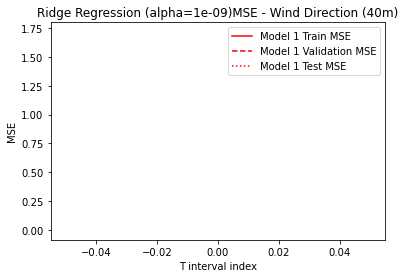

-----------------------
Low Pass Filter MSE results (models 1 & 2)
Training MSE (mean, std):  0.004258478261341018 0.01839393383284135
Validation MSE (mean, std):  0.009161439704585328 0.04558554717341227
Test MSE (mean, std):  0.09393764593851422 0.2443607992911954


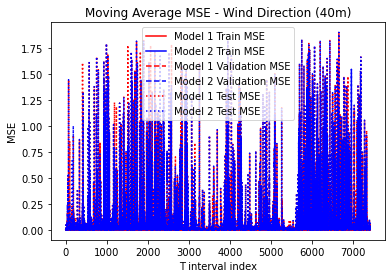

In [17]:
plot_mses(outputs_df, lam)

No handles with labels found to put in legend.


Index:  62
Regression


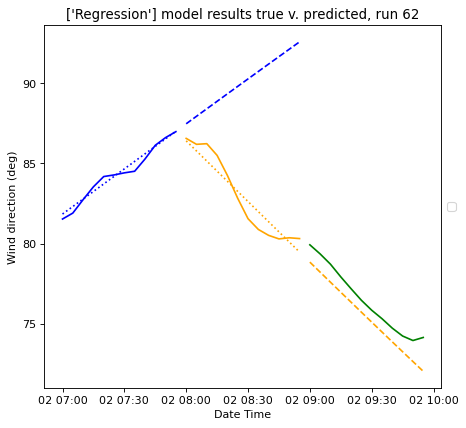

No handles with labels found to put in legend.


Index:  63
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  64
Regression


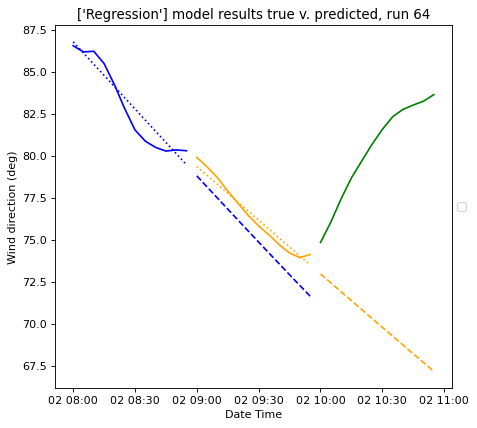

No handles with labels found to put in legend.


Index:  65
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  66
Regression


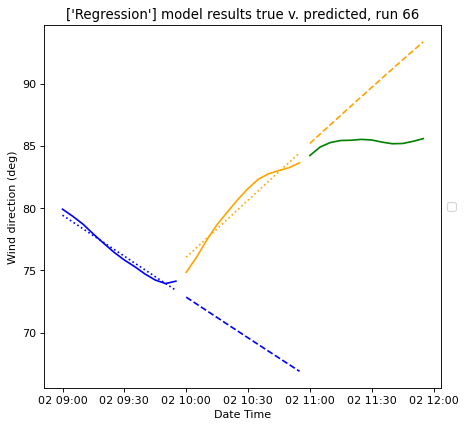

No handles with labels found to put in legend.


Index:  67
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  86
Regression


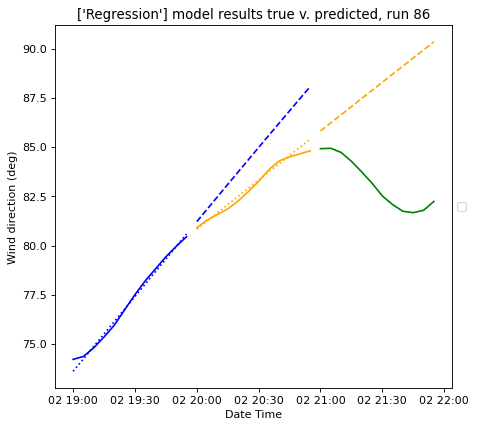

No handles with labels found to put in legend.


Index:  87
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  88
Regression


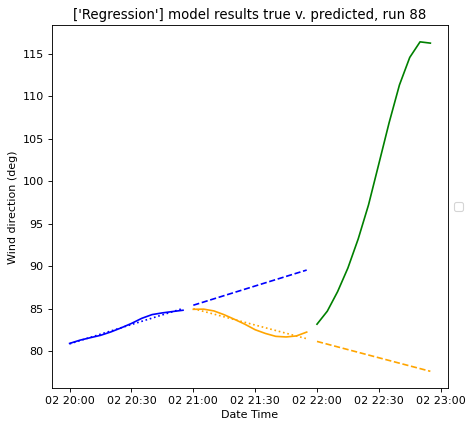

No handles with labels found to put in legend.


Index:  89
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  90
Regression


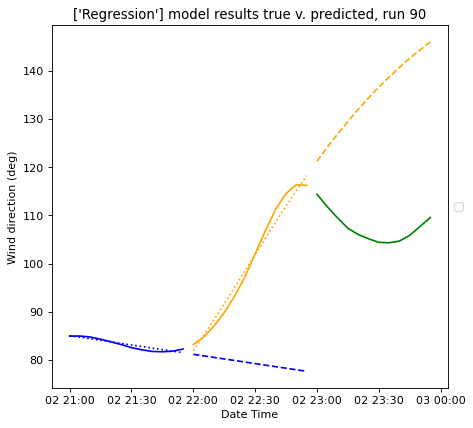

No handles with labels found to put in legend.


Index:  91
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  112
Regression


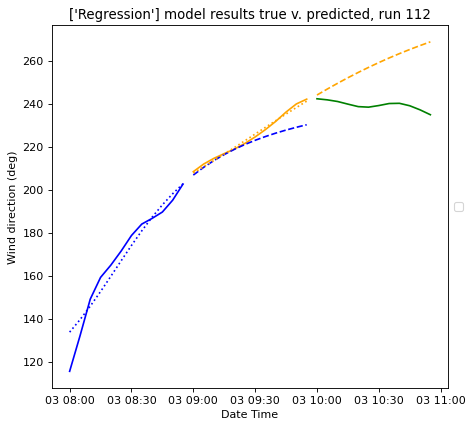

No handles with labels found to put in legend.


Index:  113
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  140
Regression


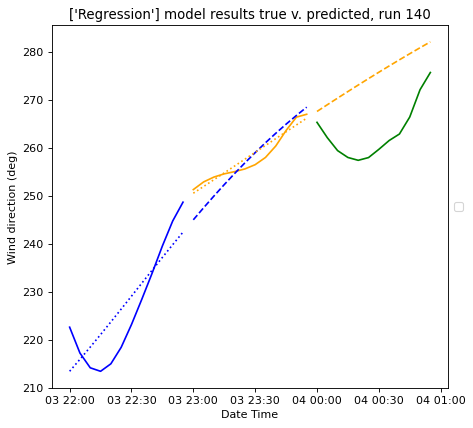

No handles with labels found to put in legend.


Index:  141
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  160
Regression


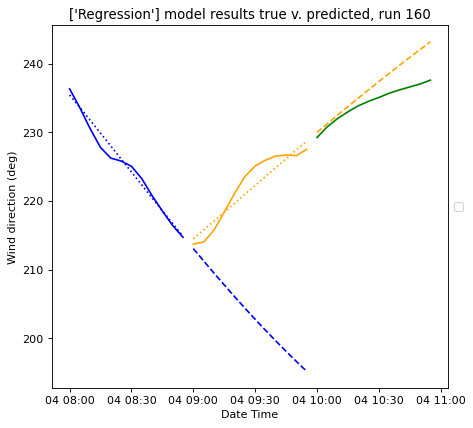

No handles with labels found to put in legend.


Index:  161
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  162
Regression


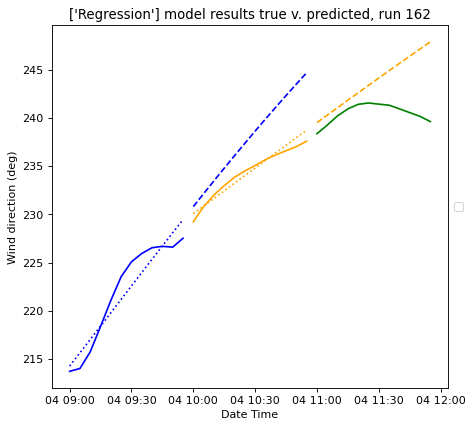

No handles with labels found to put in legend.


Index:  163
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  176
Regression


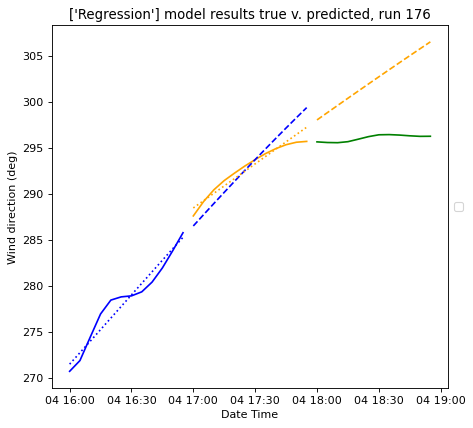

Index:  177


In [18]:
# plotting regression results
from itertools import count


regresion_results = outputs_df[outputs_df["Model Approach"]=="Regression"]
count_plots = 0
max_plots = 10
for i in regresion_results.index.values:
    try:
        print("Index: ",i)
        if count_plots > max_plots:
            break
        if outputs_df.iloc[i]["Model Approach"] == "Regression":
            print(outputs_df.iloc[i]["Model Approach"])
            plot_true_v_pred(inputs_df[i//2], outputs_df, lam, t_interval_index=i)
            count_plots += 1
    except Exception as e:
        print(f"Error: {e}")
        continue
    

No handles with labels found to put in legend.


Index:  64
Regression
(65.83021369827986, 86.61802386812289)


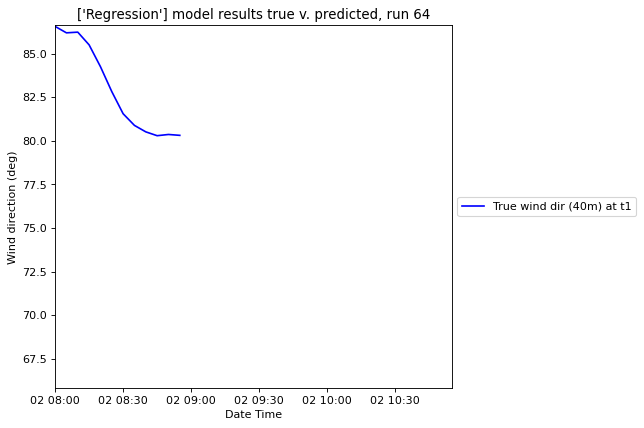

No handles with labels found to put in legend.


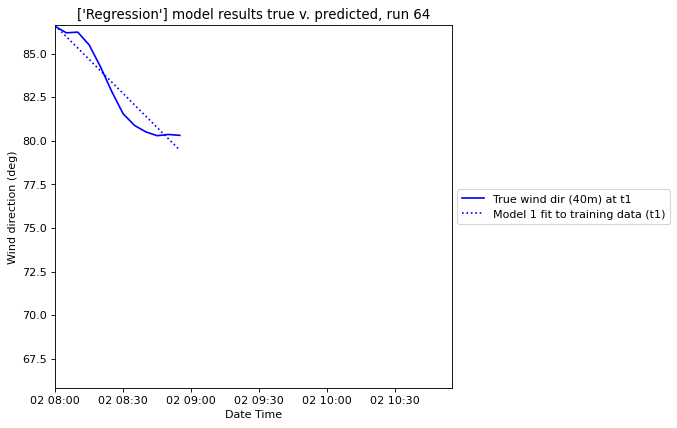

No handles with labels found to put in legend.


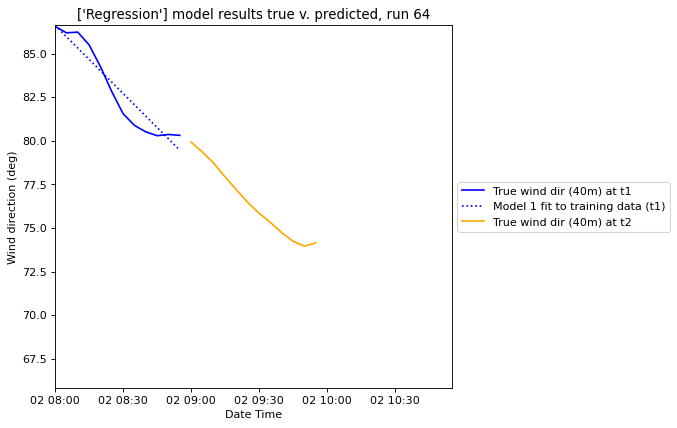

No handles with labels found to put in legend.


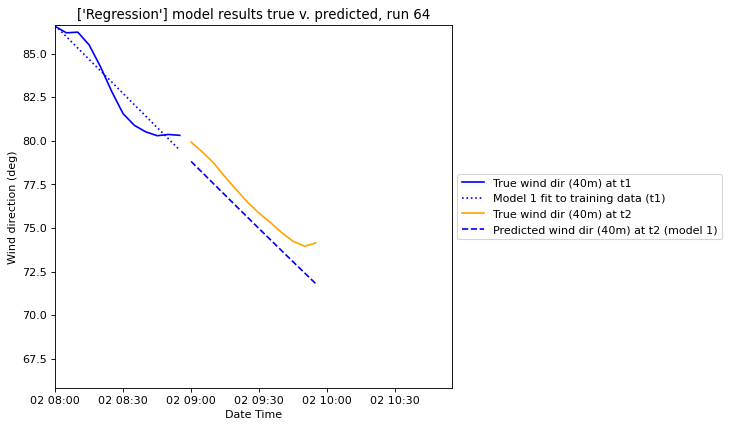

No handles with labels found to put in legend.


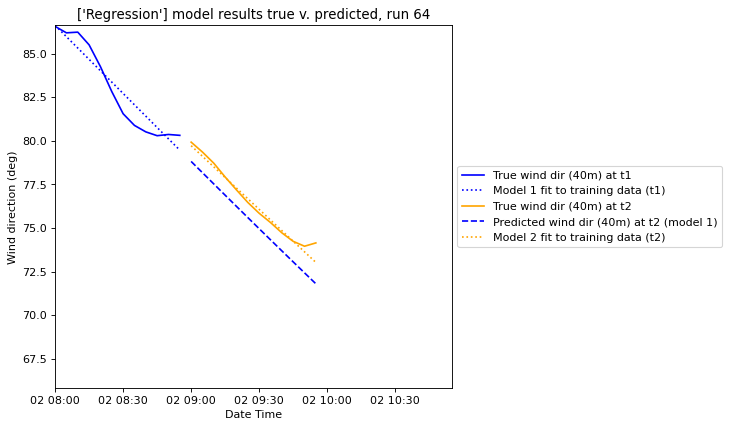

No handles with labels found to put in legend.


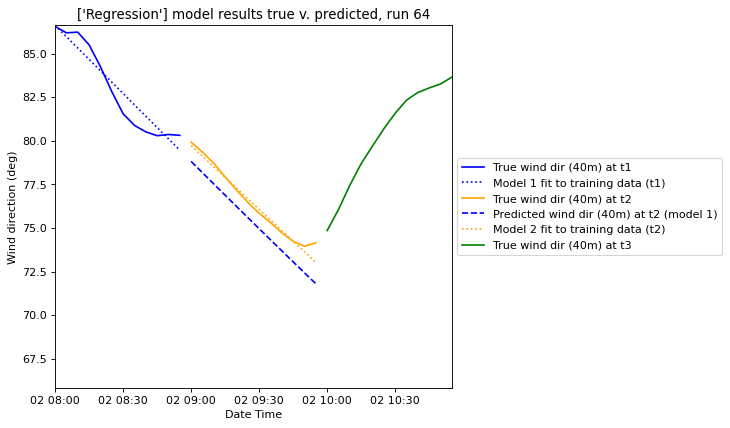

No handles with labels found to put in legend.


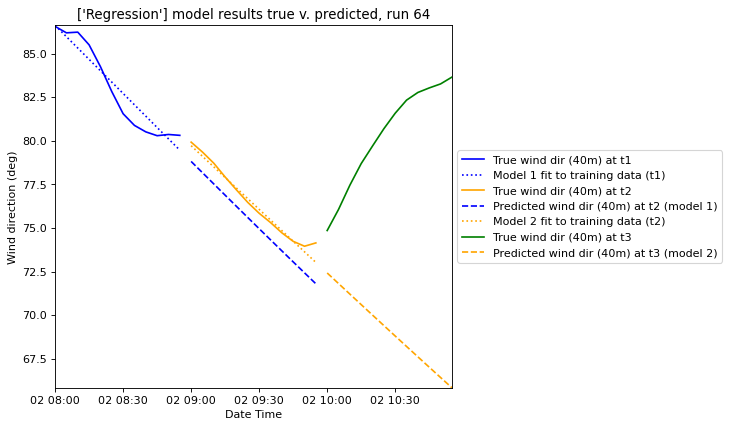

No handles with labels found to put in legend.


Index:  65
Regression
Error: index 0 is out of bounds for axis 0 with size 0
Index:  66
Regression
(66.85629349191169, 94.68600378104217)


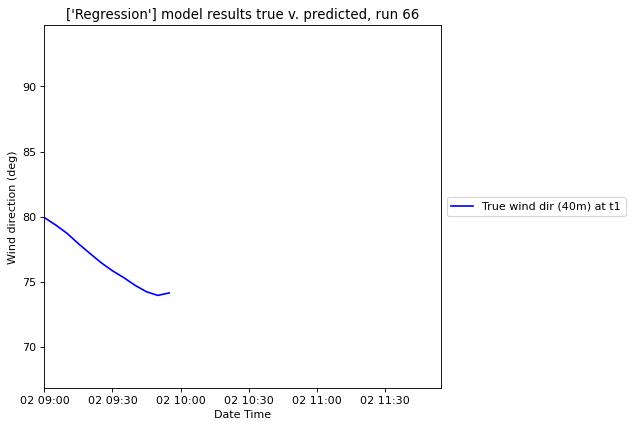

No handles with labels found to put in legend.


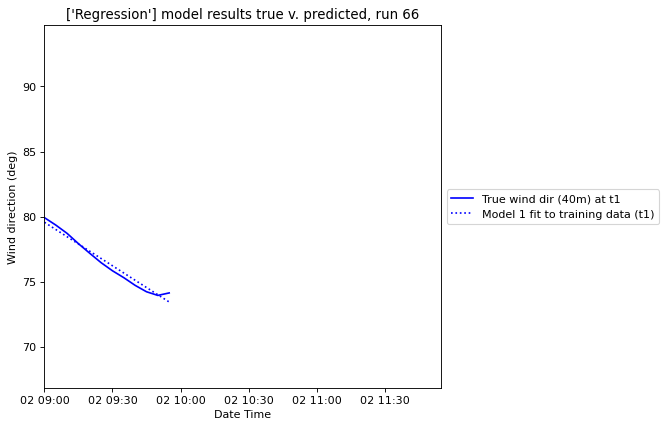

No handles with labels found to put in legend.


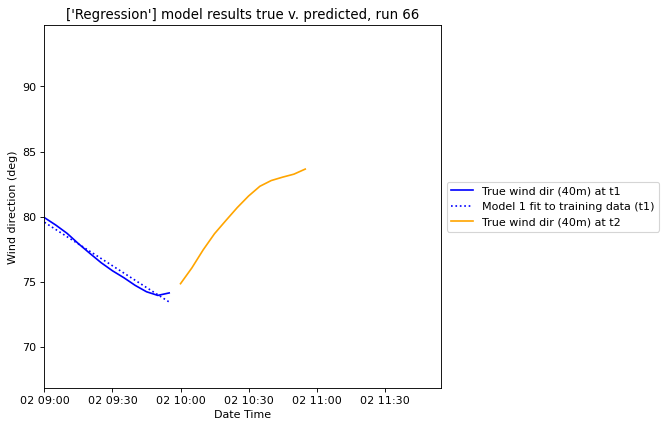

No handles with labels found to put in legend.


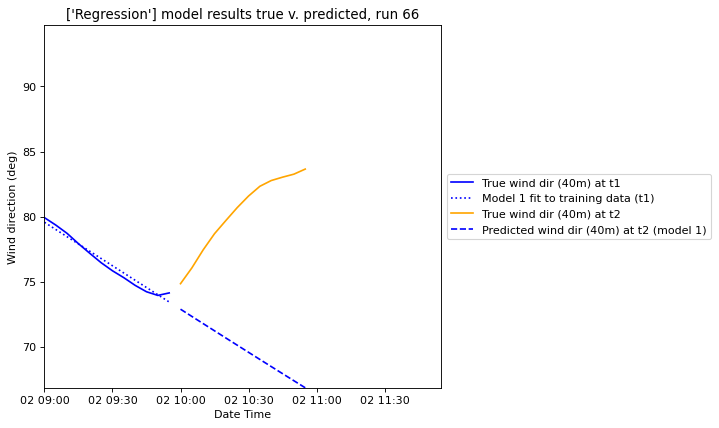

No handles with labels found to put in legend.


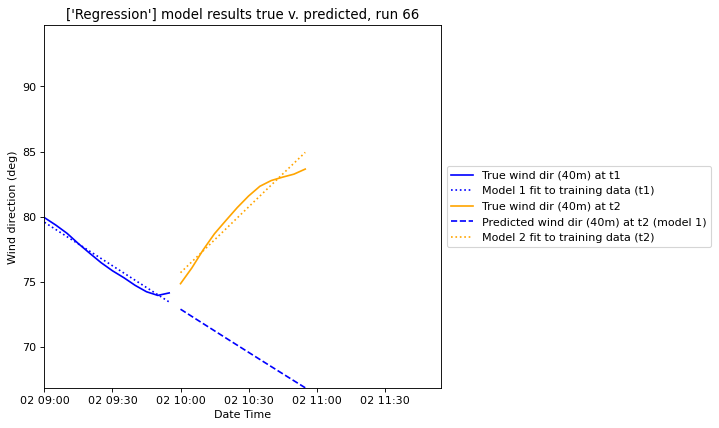

No handles with labels found to put in legend.


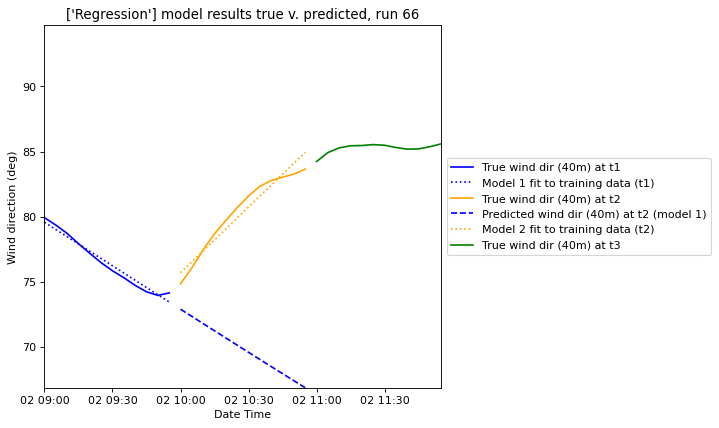

No handles with labels found to put in legend.


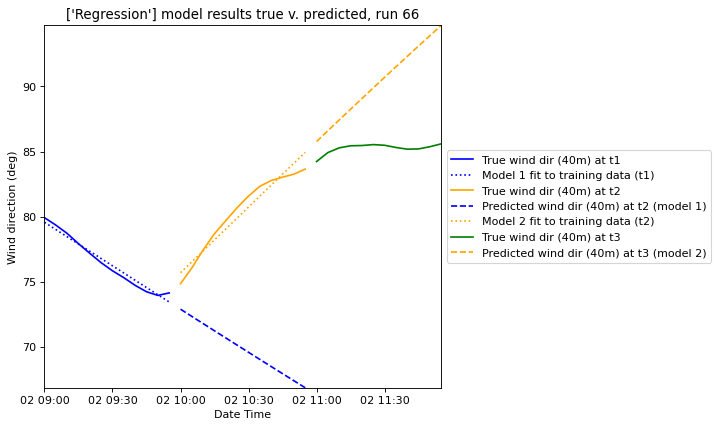

Index:  67


In [287]:
# plotting regression results
from itertools import count


regresion_results = outputs_df[outputs_df["Model Approach"]=="Regression"]
count_plots = 0
max_plots = 1
for i in regresion_results.index.values:
    try:
        print("Index: ",i)
        if count_plots > max_plots:
            break
        if outputs_df.iloc[i]["Model Approach"] == "Regression":
            print(outputs_df.iloc[i]["Model Approach"])
            plot_true_v_pred_each_step(inputs_df[i//2], outputs_df, lam, t_interval_index=i)
            plot_mse_coeff()
            count_plots += 1
    except Exception as e:
        print(f"Error: {e}")
        continue

No handles with labels found to put in legend.


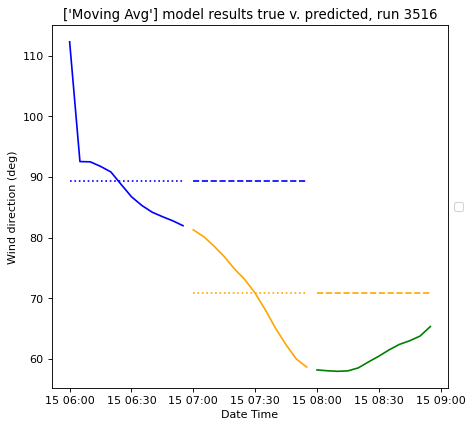

In [274]:
from random import randint, random

random_t = randint(0,outputs_df.shape[0]/2)
plot_true_v_pred(inputs_df[random_t//2], outputs_df, lam, t_interval_index=random_t)

In [19]:
def plot_approaches_temporal_share(results_df, height_meters=80):
    # color code model approaches
    regression_color = 'red'
    low_pass_filter_color = "blue"
    
    regression_condition = (results_df["Model Approach"] == "Regression")
    low_pass_filter_condition = (results_df["Model Approach"] == "Moving Average")

    mses_to_plot = ["Train MSE", "Validation MSE", "Test MSE"]
    line_styles = ["solid", "dashed", "dotted"]

    for i in range(len(mses_to_plot)):
        # plot model 1
        plt.plot(range(results_df.shape[0]//2), results_df.loc[regression_condition][mses_to_plot[i]], label="Regression "+mses_to_plot[i], color="red", linestyle=line_styles[i])
        # plot model 2
        plt.plot(range(results_df.shape[0]//2), results_df.loc[low_pass_filter_condition][mses_to_plot[i]], label="Moving Average "+mses_to_plot[i], color="blue", linestyle=line_styles[i])

    # create MSE plot axes and labels
    plt.title(f"Ridge Regression MSE - Wind Direction ({height_meters}m)")
    plt.xlabel("T interval index")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

In [20]:
# compare frequency of moving avg v regression approaches
outputs_grouped_count = outputs_df.groupby(by=["Model Approach"]).count()//2
total_count = outputs_grouped_count["Model"].values.sum()
share_of_approaches = [outputs_grouped_count["Model"]["Moving Avg"]/total_count, outputs_grouped_count["Model"]["Regression"]/total_count]
share_of_approaches

[0.8463119433660653, 0.1536880566339347]

In [19]:
# Plot the figure.
plt.figure(figsize=(12, 8))
y = pd.Series(share_of_approaches)
ax = y.plot(kind="bar")
x_labels=["Moving Average", "Ridge Regression"]

ax.set_xticklabels(x_labels, rotation=0)
ax.set_ylabel(f"Frequency of approach out of {total_count} runs")
ax.set_title(f"Frequency of approaches [T={T}s, alpha={lam}]")
ax.set_ylim([0.0, 1.0])

rects = ax.patches

for rect, label_amt in zip(rects, share_of_approaches):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height, round(label_amt,2), ha="center", va="bottom"
    )

plt.show()

NameError: name 'share_of_approaches' is not defined

<Figure size 864x576 with 0 Axes>

In [227]:
# compare use of approaches by time of day 
# day time = 6am - 7pm, night time = 7pm - 6am
def plot_diurnal_approach_trends(inputs_df, outputs_df, reg_lam, t_interval_index=0, height_meters=40):
    # define day time hour condition
    day_hour_range = [6,19]
    
    # t indices
    t_test = outputs_df["Test set"][:,0]
    # convert t indices to datetime
    outputs_df["Test set_dt"] = pd.to_datetime(t_test, unit="s")

    # filter by time of day
    day_df = outputs_df.loc[outputs_df["Test set_dt"].dt.hour in range(day_hour_range)].reset_index()
    night_df = outputs_df.loc[outputs_df["Test set_dt"].dt.hour not in range(day_hour_range)].reset_index()
    
    # day time plotting
    outputs_grouped_count = day_df.groupby(by=["Model Approach"]).count()//2
    total_count = outputs_grouped_count["Model"].values.sum()
    share_of_approaches_daytime = [outputs_grouped_count["Model"]["Moving Avg"]/total_count, outputs_grouped_count["Model"]["Regression"]/total_count]
    
    # night time plotting
    outputs_grouped_count = night_df.groupby(by=["Model Approach"]).count()//2
    total_count = outputs_grouped_count["Model"].values.sum()
    share_of_approaches_nighttime = [outputs_grouped_count["Model"]["Moving Avg"]/total_count, outputs_grouped_count["Model"]["Regression"]/total_count]
    
    return {"daytime moving avg v regression": share_of_approaches_daytime, "nighttime moving avg v regression": share_of_approaches_nighttime }
    
        

In [228]:
# Plot the figure.
daytime_v_nighttime = plot_diurnal_approach_trends(inputs_df, outputs_df, lam)

plt.figure(figsize=(12, 8))
daytime = pd.Series(daytime_v_nighttime["daytime moving avg v regression"])
ax = daytime.plot(kind="bar")
x_labels=["Moving Average", "Ridge Regression"]

ax.set_xticklabels(x_labels, rotation=0)
ax.set_ylabel(f"Frequency of approach out of {total_count} runs")
ax.set_title(f"Frequency of approaches [T={T}s, alpha={lam}]")
ax.set_ylim([0.0, 1.0])

rects = ax.patches

for rect, label_amt in zip(rects, share_of_approaches):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height, round(label_amt,2), ha="center", va="bottom"
    )

plt.show()

KeyError: 'key of type tuple not found and not a MultiIndex'

### Just Regression Approach

In [356]:
T = 5*60*12 # 12 rows of 5 mins -> 1 hr (in seconds) 
lam = 10**(-5)
temoral_res_secs = 5*60
height_m = 80
R_min = 0.0
regression_inputs_df, regressions_df = run_algorithm(data_df, T, temporal_res=temoral_res_secs,R_min=R_min,height_meters=height_m,lam=lam)

Length of values (0) does not match length of index (12)
Length of values (0) does not match length of index (12)
fit MSE 0.20342757090447638
mean MSE  0.00550620876507502
R_1  0.15978285721628754
R_2  -0.29508188592212603
---------------
fit MSE 0.20230162178229716
mean MSE  0.006803403950345638
R_1  0.4236495576786878
R_2  0.681319078625978
---------------
fit MSE 0.2061228201660484
mean MSE  0.0014700060620111346
R_1  0.3810928827351606
R_2  0.04394335849899883
---------------
fit MSE 0.1685303335847226
mean MSE  0.05528375544887015
R_1  0.228693373248343
R_2  0.22205057266587136
---------------
fit MSE 0.16272834124840516
mean MSE  0.06158894760560172
R_1  0.32134580440827204
R_2  0.35807002278520794
---------------
fit MSE 0.18002684603130023
mean MSE  0.03911440029497235
R_1  -23.61123064297059
R_2  -1.206263144557802
---------------
fit MSE 0.15508944589970677
mean MSE  0.07318729230717387
R_1  -3.8589929309544595
R_2  -0.7659356871740687
---------------
fit MSE 0.15117593852921

Ridge Regression MSE results (models 1 & 2), lam= 1e-05
Training MSE (mean, std):  0.004827886147521001 0.015669100762758976
Validation MSE (mean, std):  0.0056891744628344825 0.016094938171911523
Test MSE (mean, std):  2.0877550945283745 1.508647689126579


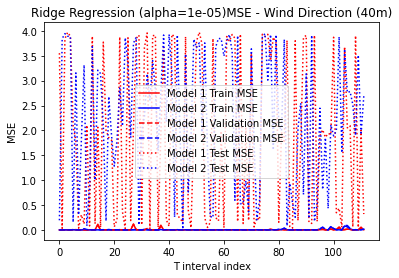

-----------------------
Low Pass Filter MSE results (models 1 & 2)
Training MSE (mean, std):  0.017595986547174633 0.04436850846949468
Validation MSE (mean, std):  0.026248412945157635 0.06651463823192594
Test MSE (mean, std):  0.1782199794725624 0.3115075420199167


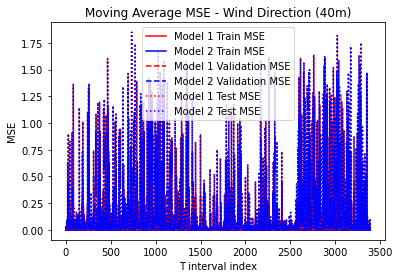

In [357]:
plot_mses(outputs_df, lam)

#### Just Low-Pass Filter

In [ ]:
T = 5*60*12 # 12 rows of 5 mins -> 1 hr (in seconds) 
lam = 10**(-5)
temoral_res_secs = 5*60
height_m = 80
R_min = 1.0
inputs_df, outputs_df = run_algorithm(data_df, T, temporal_res=temoral_res_secs,R_min=R_min,height_meters=height_m,lam=lam)

Length of values (0) does not match length of index (12)
Length of values (0) does not match length of index (12)
fit MSE 0.2034222842550564
mean MSE  0.00550620876507502
R_1  0.8106411741489592
R_2  -0.7128725848913802
---------------
fit MSE 0.2022805326194879
mean MSE  0.006803403950345638
R_1  0.806593330103996
R_2  0.6815490277137737
---------------
fit MSE 0.20607675681483198
mean MSE  0.0014700060620111346
R_1  -6.512041023612023
R_2  -1.3254028515134426
---------------
fit MSE 0.1679589985712113
mean MSE  0.05528375544887015
R_1  -0.12152790618156173
R_2  -0.5854951828302245
---------------
fit MSE 0.162151644609803
mean MSE  0.06158894760560172
R_1  0.318814329336711
R_2  0.9609494748761586
---------------
fit MSE 0.17909696934450792
mean MSE  0.03911440029497235
R_1  0.5717184528276253
R_2  -26.142900368186368
---------------
fit MSE 0.15379875111972977
mean MSE  0.07318729230717387
R_1  -81.42624807448375
R_2  0.8809356356942579
---------------
fit MSE 0.15110234556277127
me

Ridge Regression MSE results (models 1 & 2), lam= 1e-05
Training MSE (mean, std):  nan nan
Validation MSE (mean, std):  nan nan
Test MSE (mean, std):  nan nan


/Users/anafiallo/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anafiallo/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/anafiallo/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/anafiallo/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/anafiallo/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


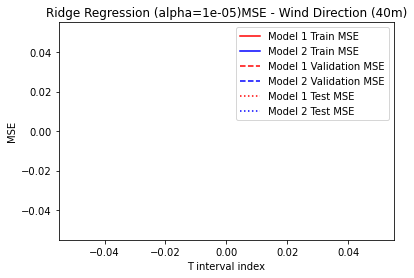

-----------------------
Low Pass Filter MSE results (models 1 & 2)
Training MSE (mean, std):  3.435618794714463e-12 2.3108151071768963e-11
Validation MSE (mean, std):  0.009853204404990422 0.04656753724169013
Test MSE (mean, std):  0.015367715840600888 0.051498827010655834


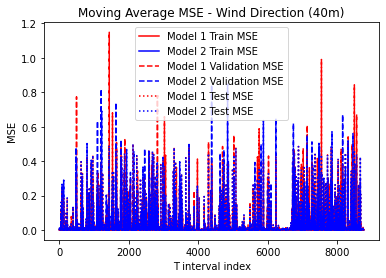

In [ ]:
plot_mses(outputs_df, lam)

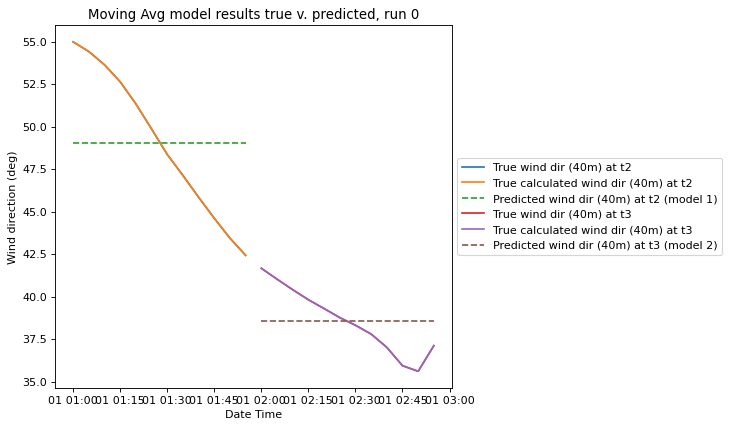

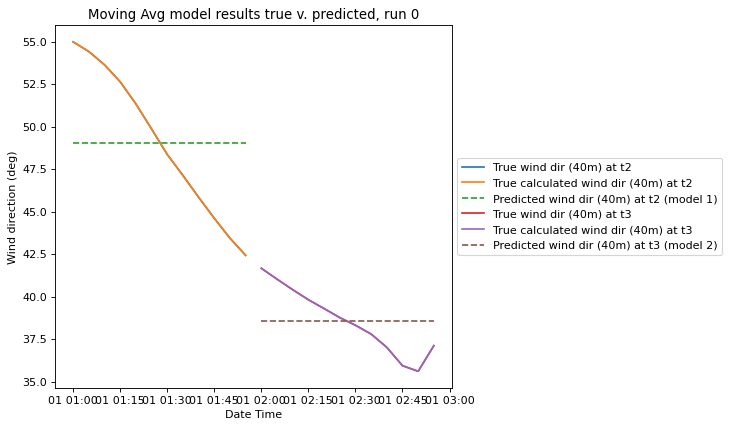

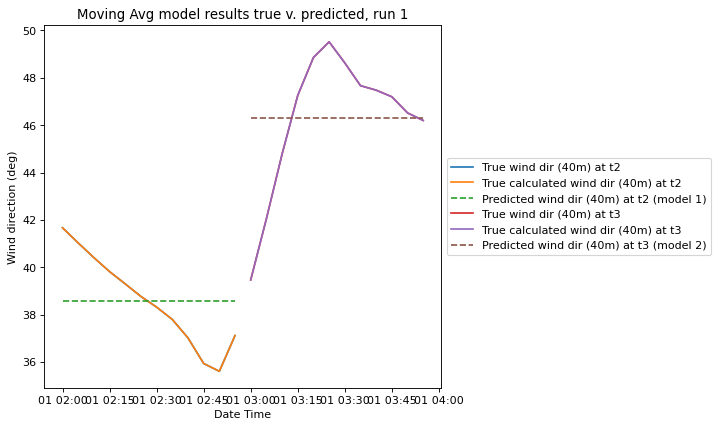

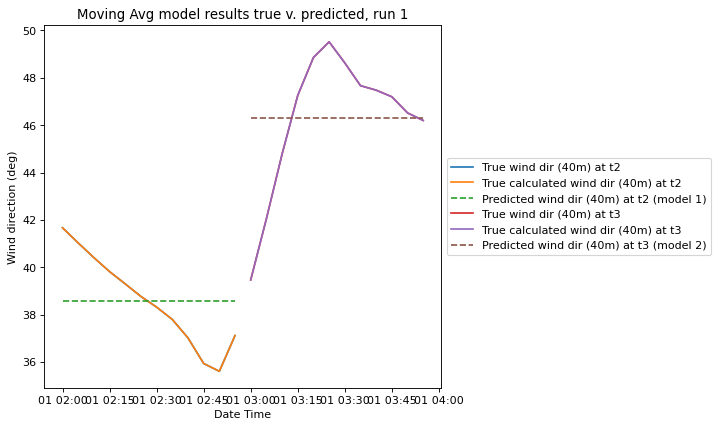

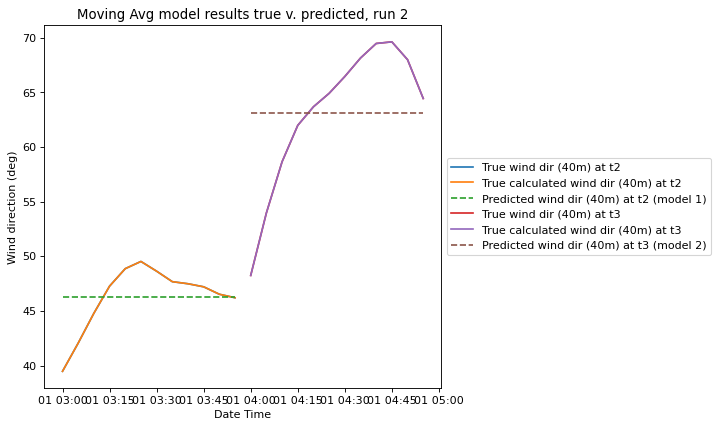

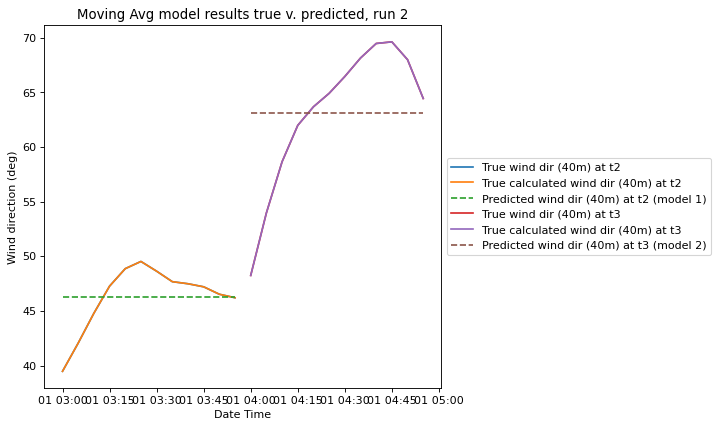

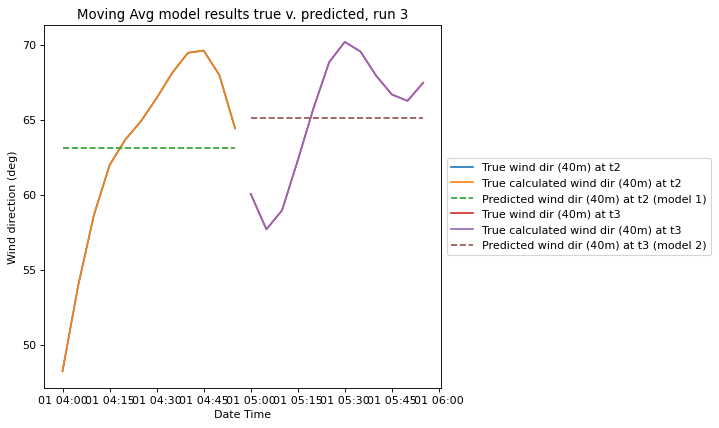

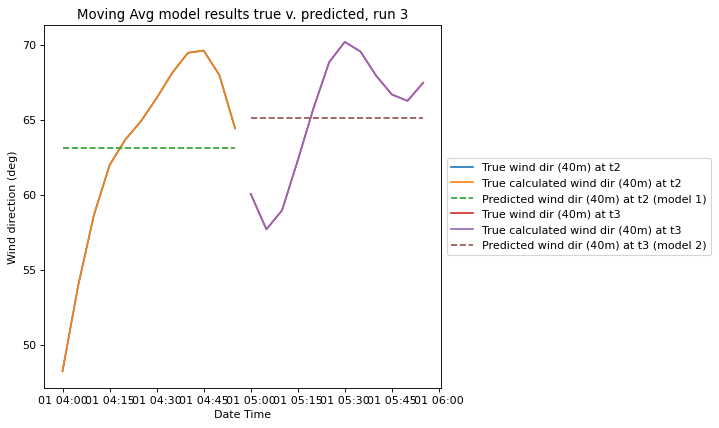

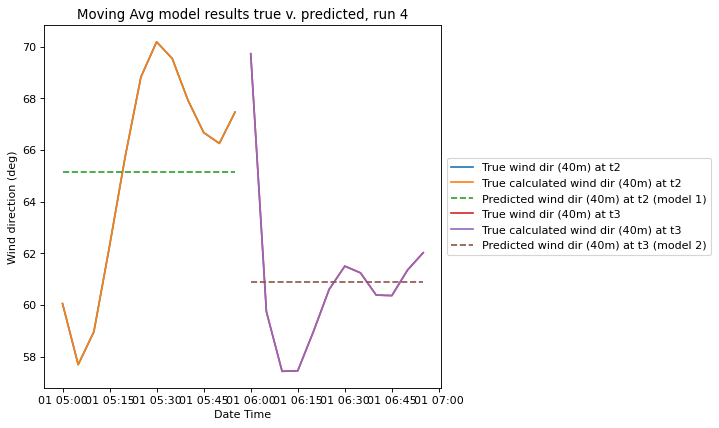

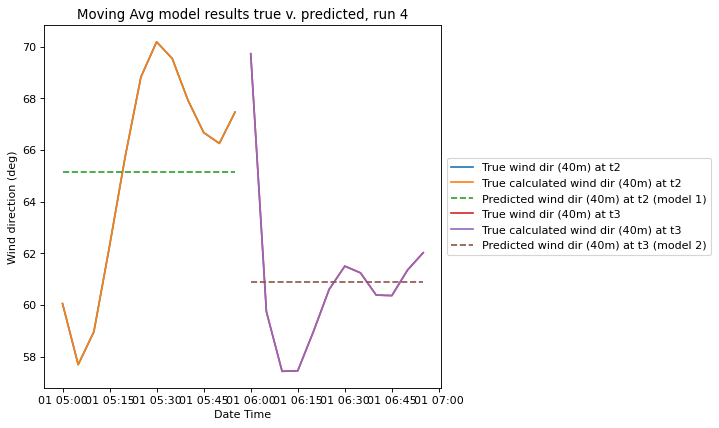

In [ ]:
# plotting low pass filter results
regresion_results = outputs_df[outputs_df["Model Approach"]=="Moving Avg"]
for i in range(10):
    run_index = i//2
    plot_true_v_pred(regresion_results, lam, t_interval_index=run_index)